# Organoid spike detection

In [1]:
%load_ext autoreload
import sys
sys.path.append("/home/timsit/mecp2/python/")
import mea_util
import mat73  # load big matlab files
import spike_detection as dspikes
import process_spikes as pspikes
import vizpikes 

import numpy as np
import xarray as xr
import pandas as pd

# Signal processing 
import scipy.signal as ssignal

# dashboard
import panel as pn
from panel.interact import fixed
import param

# plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt
import sciplotlib.polish as splpolish 
import sciplotlib.style as splstyle

import os 
import glob
import pickle as pkl
import h5py
# For downloading df to csv 
from io import StringIO

# analysis 
# 
# import process_spikes as pspikes



# Network
import networkx as nx

# Bokeh 
import bokeh as bk
from bokeh.io import output_file, show
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool, StaticLayoutProvider)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx

pn.extension()

# Datashader and holoviz for large plots 
from holoviews.operation.datashader import datashade
import holoviews as hv
import datashader as ds
renderer = hv.renderer('bokeh')

import re


/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.imputils', please update to use 'numba.core.imputils' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'impl_ret_borrowed' requested from: 'numba.targets.imputils', pleas

# Threshold method

In [62]:
# main_data_folder = '/media/timsit/Seagate Expansion Drive/The_Mecp2_Project/organoid_data/spikes'
main_data_folder = '/media/timsit/phts2/tempData/spikes/'
# spike_detection_method_subfolder = '/media/timsit/phts2/tempData/spikes/CWT_param_search/all_duration'
spike_detection_method_subfolder = '/media/timsit/Seagate Expansion Drive/The_Mecp2_Project/organoid_data/spikes/thresholdParamSearch/'
file_ext = '*.mat'

mat_data_dict = dict()

for file_path in glob.glob(os.path.join(main_data_folder, spike_detection_method_subfolder, file_ext)):
    # mat_data = mea_util.loadmat(file_path)
    mat_data = mat73.loadmat(file_path)
    file_name = os.path.basename(file_path).split('.')[0]
    mat_data_dict[file_name] = mat_data

In [64]:
spike_df_list = list()

other_param_to_include = ['multiplier']
# other_param_to_include = ['L']

for file_name, file_data in mat_data_dict.items():
    
    recording_date = file_name.split('_')[0]
    # %s is the place holder for the string 
    # \d matches the digit 
    # + matches between one and unlimited times 
    # () capturing group
    slice_number_query = re.findall(r'%s(\d+)' % 'slice', file_name)
    if len(slice_number_query) == 1:
        slice_number = int(slice_number_query[0])
    else:
        print('Warning: slice number not found')
        slice_number = np.nan
        
    spike_times_dict = file_data['spikeDetectionResult']['spikeTimes']
    
    if 'L' in other_param_to_include:
        L_param_val = file_data['L']
    if 'multiplier' in  other_param_to_include:
        m = file_data['spikeDetectionResult']['params']['multiplier']
    
    # Convert spikeTimes dict to pandas dataframe
    channel_list = list()
    spike_time_list = list()
    for channel_name, channel_spike_times in spike_times_dict.items():
        
        channel_num = int(re.findall(r'%s(\d+)' % 'channel', channel_name)[0])
        channel_num_spikes = channel_spike_times.size
        
        if channel_num_spikes  == 1:
            
            spike_time_list.extend([channel_spike_times])
            channel_list.extend(np.repeat(channel_num, channel_num_spikes))
        
        else:
        
            spike_time_list.extend(channel_spike_times)
            channel_list.extend(np.repeat(channel_num, channel_num_spikes))
    
    if 'TTX' in file_name:
        added_TTX = True
    else:
        added_TTX = False
    
    spike_df = pd.DataFrame.from_dict({
        'channel': channel_list,
        'spikeTime': spike_time_list,
        'slice_number': slice_number,
        'recording_date': recording_date,
        'TTX': added_TTX
    })
    
    if 'L' in other_param_to_include:
        spike_df['L'] = L_param_val
    if 'multiplier' in other_param_to_include:
        spike_df['multiplier'] = m
    
    spike_df_list.append(spike_df)

all_file_spike_df = pd.concat(spike_df_list)

# Look at pre-post TTX num spikes

## For one single slice

In [65]:
np.max(all_file_spike_df['spikeTime'])

359.99988

In [90]:
target_slice_number = 1
target_recording_date = '200708'
target_L_param = None
target_multiplier = 3

slice_spike_df = all_file_spike_df.loc[
    (all_file_spike_df['slice_number'] == target_slice_number) & 
    (all_file_spike_df['recording_date'] == target_recording_date)
]



if target_L_param is not None:
    unique_L_param = np.unique(slice_spike_df['L'])
    print('L param used: %.5f' % target_L_param)
    slice_spike_df = slice_spike_df.loc[
        slice_spike_df['L'] == target_L_param
    ]
    
if target_multiplier is not None:
    slice_spike_df = slice_spike_df.loc[
        slice_spike_df['multiplier'] == target_multiplier
    ]

slice_grouped_spike_count = slice_spike_df.groupby(['TTX', 'channel']).agg('count')['spikeTime'].reset_index()
min_spike_count = np.min(slice_grouped_spike_count['spikeTime'])
max_spike_count = np.max(slice_grouped_spike_count['spikeTime'])

print('Minimum spike count in channel: %.f' % min_spike_count)
print('Maximum spike count in channel: %.f' % max_spike_count)

Minimum spike count in channel: 1
Maximum spike count in channel: 55872


In [91]:
def plot_pre_post_TTX_channel_spike_count(slice_spike_df, slice_grouped_spike_count):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(4, 4)
    pad_value = 10
    
    min_spike_count = np.min(slice_grouped_spike_count['spikeTime'])
    max_spike_count = np.max(slice_grouped_spike_count['spikeTime'])

    for channel in np.unique(slice_spike_df['channel']):

        channel_pre_TTX_spike_count = slice_grouped_spike_count.loc[
            (slice_grouped_spike_count['TTX'] == False) &
            (slice_grouped_spike_count['channel'] == channel)
        ]

        channel_post_TTX_spike_count = slice_grouped_spike_count.loc[
            (slice_grouped_spike_count['TTX'] == True) &
            (slice_grouped_spike_count['channel'] == channel)
        ]
        
        # TODO: double check that this is correct
        if len(channel_pre_TTX_spike_count) == 0:
            channel_pre_TTX_spike_count_val = 0
        else:
            channel_pre_TTX_spike_count_val = channel_pre_TTX_spike_count['spikeTime']
            
        if len(channel_post_TTX_spike_count) == 0:
            channel_post_TTX_spike_count_val = 0
        else:
            channel_post_TTX_spike_count_val = channel_post_TTX_spike_count['spikeTime']

        ax.scatter(channel_pre_TTX_spike_count_val, 
                   channel_post_TTX_spike_count_val, 
                   color='black', alpha=0.2, edgecolor='none')
        
    ax.set_xlabel('Before TTX spike count', size=12)
    ax.set_ylabel('After TTX spike count', size=12)
    
    unity_vals = np.linspace(min_spike_count - pad_value, max_spike_count + pad_value, 1000)
    ax.plot(unity_vals, unity_vals, linestyle='--', color='gray')
    
    x_lower_lim = np.max([min_spike_count - pad_value, 0])
    
    ax.set_xlim([x_lower_lim, max_spike_count + pad_value])
    ax.set_ylim([x_lower_lim, max_spike_count + pad_value])
    
    return fig, ax 

TypeError: must be real number, not NoneType

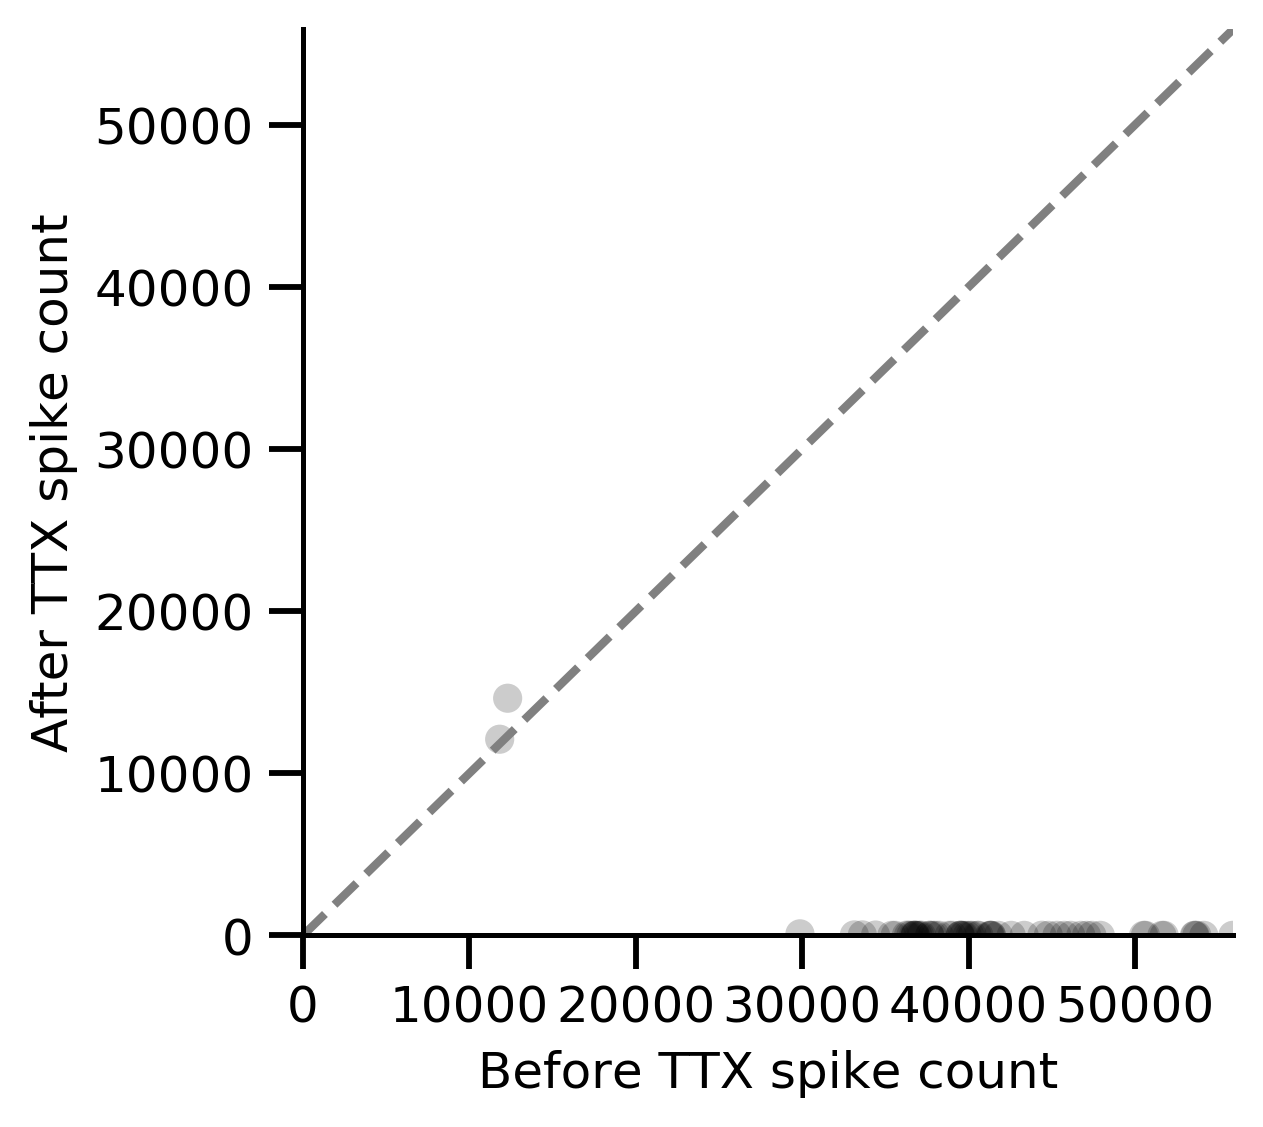

In [92]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, ax = plt.subplots()
    fig.set_size_inches(4, 4)
    pad_value = 10

    for channel in np.unique(all_file_spike_df['channel']):

            
        channel_pre_TTX_spike_count = slice_grouped_spike_count.loc[
            (slice_grouped_spike_count['TTX'] == False) &
            (slice_grouped_spike_count['channel'] == channel)
        ]

        channel_post_TTX_spike_count = slice_grouped_spike_count.loc[
            (slice_grouped_spike_count['TTX'] == True) &
            (slice_grouped_spike_count['channel'] == channel)
        ]
        

        

        ax.scatter(channel_pre_TTX_spike_count['spikeTime'], 
                   channel_post_TTX_spike_count['spikeTime'], 
                   color='black', alpha=0.2, edgecolor='none')
        
    ax.set_xlabel('Before TTX spike count', size=12)
    ax.set_ylabel('After TTX spike count', size=12)
    
    unity_vals = np.linspace(min_spike_count - pad_value, max_spike_count + pad_value, 1000)
    ax.plot(unity_vals, unity_vals, linestyle='--', color='gray')
    
    x_lower_lim = np.max([min_spike_count - pad_value, 0])
    
    ax.set_xlim([x_lower_lim, max_spike_count + pad_value])
    ax.set_ylim([x_lower_lim, max_spike_count + pad_value])
    
    # ax.set_xticks([min_spike_count, max_spike_count])
    # ax.set_yticks([min_spike_count, max_spike_count])
    
    ax.set_title('%s slice %.f,  $L = %.4f$' % (target_recording_date, target_slice_number, target_L_param), size=10)
    fig_name = '%s_slice_%.f_unity_plot_60seconds_L_%.4f' % (target_recording_date, target_slice_number, target_L_param)
    
    # fig_folder = '/media/timsit/Seagate Expansion Drive/The_Mecp2_Project/organoid_figures/pre_post_TTX/all_duration_L_param_unity/'
    fig_folder = '/media/timsit/phts2/tempData/figures/all_duration_L_param_unity/'
    # fig.savefig(os.path.join(fig_folder, fig_name), bbox_inches='tight', dpi=300)

### Loop over each slice to make the unity plot

In [93]:
slice_L_spike_df

channel spikeTime  slice_number recording_date    TTX  multiplier
0         12    3.4878             1         200708  False         6.0
1         12    4.3156             1         200708  False         6.0
2         12   4.70856             1         200708  False         6.0
3         12    4.7086             1         200708  False         6.0
4         12    4.7516             1         200708  False         6.0
..       ...       ...           ...            ...    ...         ...
115       85         1             1         200708   True         6.0
116       86         0             1         200708   True         6.0
117       86         1             1         200708   True         6.0
118       87         0             1         200708   True         6.0
119       87         1             1         200708   True         6.0

[3301 rows x 6 columns]

In [82]:
for r_date in np.unique(all_file_spike_df['recording_date']):
    
    r_date_df = all_file_spike_df.loc[
        all_file_spike_df['recording_date'] == r_date
    ]
    
    for slice_number in np.unique(r_date_df['slice_number']):
        
        slice_spike_df = r_date_df.loc[r_date_df['slice_number'] == slice_number]
        
        # for L_param in np.unique(slice_spike_df['L']):
        for L_param in np.unique(slice_spike_df['multiplier']):
            # slice_L_spike_df = slice_spike_df.loc[slice_spike_df['L'] == L_param]
            slice_L_spike_df = slice_spike_df.loc[slice_spike_df['multiplier'] == L_param]

            slice_grouped_spike_count = slice_L_spike_df.groupby(['TTX', 'channel']).agg('count')['spikeTime'].reset_index()
    
            with plt.style.context(splstyle.get_style('nature-reviews')):
                fig, ax = plot_pre_post_TTX_channel_spike_count(slice_L_spike_df, slice_grouped_spike_count)
                ax.set_title('%s slice %.f,  $M = %.4f$' % (r_date, slice_number, L_param), size=10)
                fig_name = '%s_slice_%.f_unity_plot_60seconds_L_%.4f' % (r_date, slice_number, L_param)
                # fig_folder = '/media/timsit/Seagate Expansion Drive/The_Mecp2_Project/organoid_figures/pre_post_TTX/60_second_L_param_unity/'
                # fig_folder = '/media/timsit/phts2/tempData/figures/all_duration_L_param_unity/'
                fig_folder = '/media/timsit/Seagate Expansion Drive/The_Mecp2_Project/organoid_data/spikes/figures/'
                fig_ext = '.png'
                fig.savefig(os.path.join(fig_folder, fig_name + fig_ext), bbox_inches='tight', dpi=300)
                plt.close(fig)

## Wavelet method

In [5]:
example_wavelet_file = '/media/timsit/Seagate Expansion Drive/The_Mecp2_Project/organoid_data/spikes/customCWT_multiplier_3/200617_slice1_spikes.mat'
cwt_spike_detection_data = mat73.loadmat(example_wavelet_file)

In [ ]:
# example_ttx_wavelet_file = ''
# ttx_cwt_spike_detection_data = mat73.loadmat(example_ttx_wavelet_file)

In [26]:
filtered_traces = cwt_spike_detection_data['traces']
fs = cwt_spike_detection_data['spikeDetectionResult']['fs']
channel_names =  cwt_spike_detection_data['channels']

In [27]:
channel_names

array([47., 48., 46., 45., 38., 37., 28., 36., 27., 17., 26., 16., 35.,
       25., 15., 14., 24., 34., 13., 23., 12., 22., 33., 21., 32., 31.,
       44., 43., 41., 42., 52., 51., 53., 54., 61., 62., 71., 63., 72.,
       82., 73., 83., 64., 74., 84., 85., 75., 65., 86., 76., 87., 77.,
       66., 78., 67., 68., 55., 56., 58., 57.])

In [28]:
channel_spike_df = slice_spike_df.loc[slice_spike_df['channel'] == channel_names[channel_idx_to_plot]]

In [32]:
channel_spike_df['spikeTime']

1202      1.30504
1203      2.28572
1204      3.82908
1205      4.66348
1206      7.71828
          ...    
1318    352.84460
1319    356.55112
1320    357.70664
1321    357.78888
1322    359.63872
Name: spikeTime, Length: 376, dtype: float64

/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


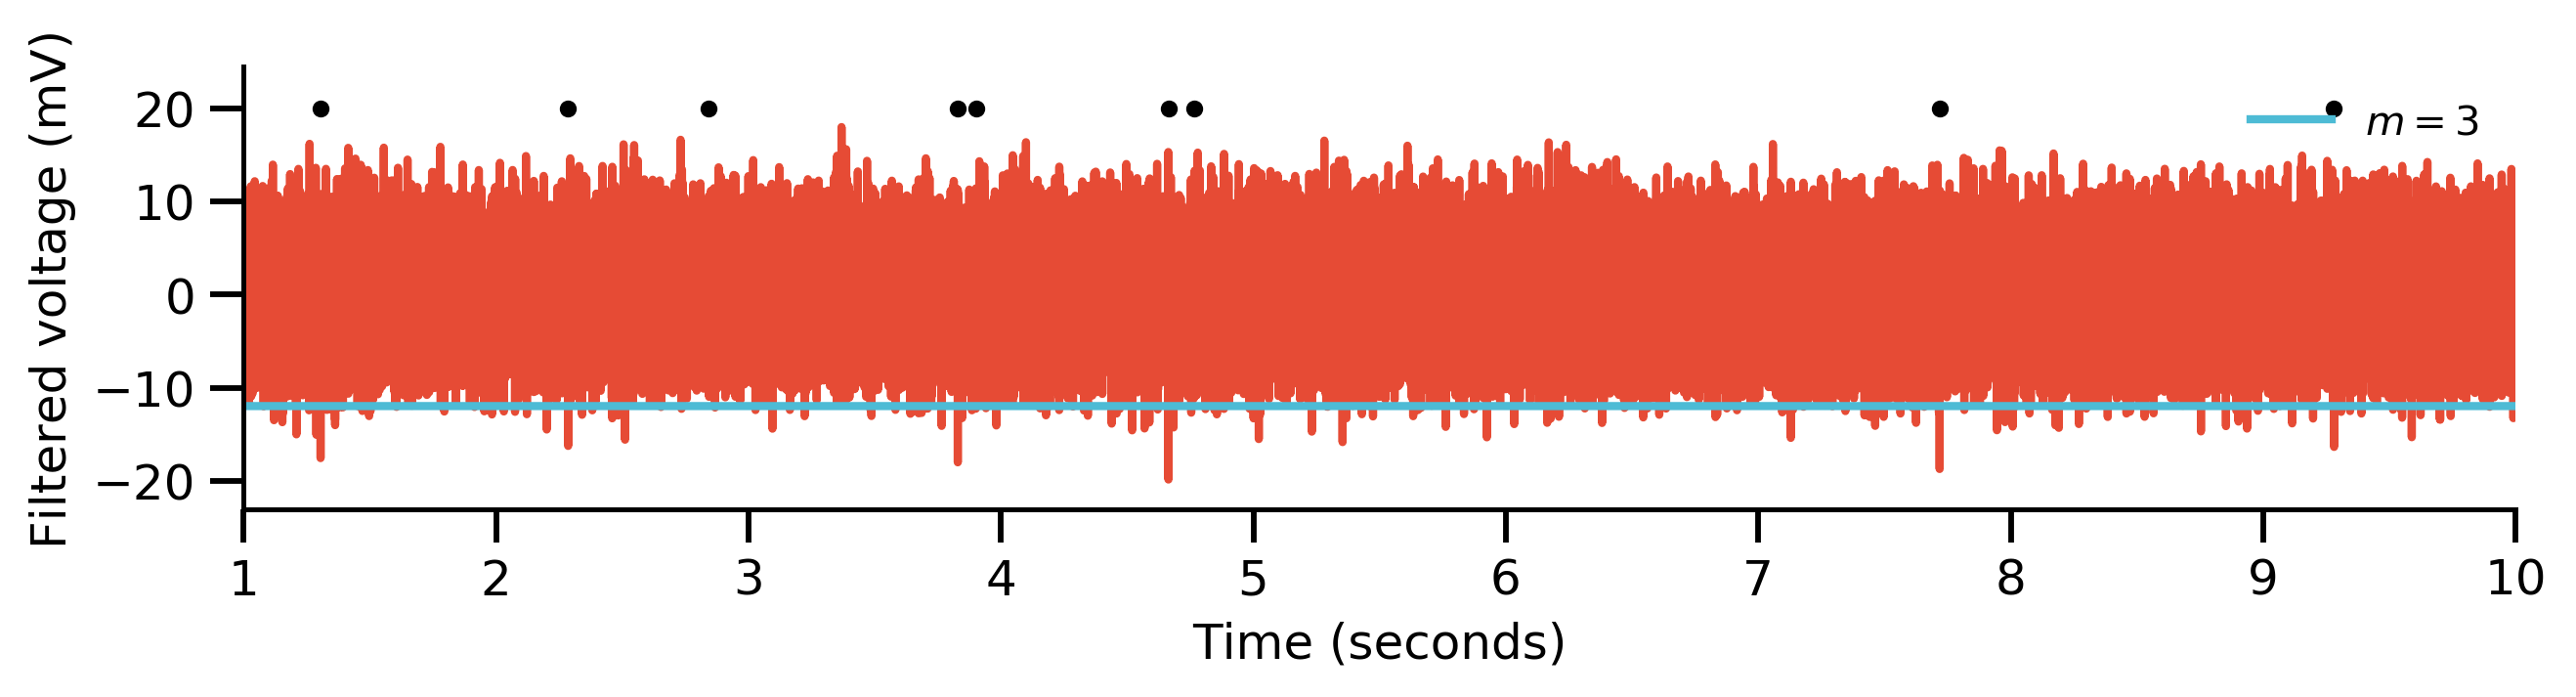

In [34]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 2)
    
    time_range = [1, 10]
    channel_idx_to_plot = 5
    num_samples = np.shape(filtered_traces)[1]
    time_in_sec = np.arange(num_samples) / fs
    ax.plot(time_in_sec, filtered_traces[channel_idx_to_plot, :])
    
    channel_std = np.std(filtered_traces[channel_idx_to_plot, :])
    channel_median = np.median(filtered_traces[channel_idx_to_plot, :])

    multiplier = 3
    ax.plot(time_in_sec, np.repeat(channel_median - channel_std * multiplier, len(time_in_sec)), 
           label=r'$m = 3$')
    
    ax.legend()
    
    # scatter spikes
    channel_spike_df = slice_spike_df.loc[slice_spike_df['channel'] == channel_names[channel_idx_to_plot]]
    spike_y_loc = 20
    ax.scatter(channel_spike_df['spikeTime'].values, 
               np.repeat(spike_y_loc, len(channel_spike_df['spikeTime'])), color='black', 
              s=10)
    
    ax.set_xlim(time_range)
    
    ax.set_xlabel('Time (seconds)', size=12)
    ax.set_ylabel('Filtered voltage (mV)', size=12)
    


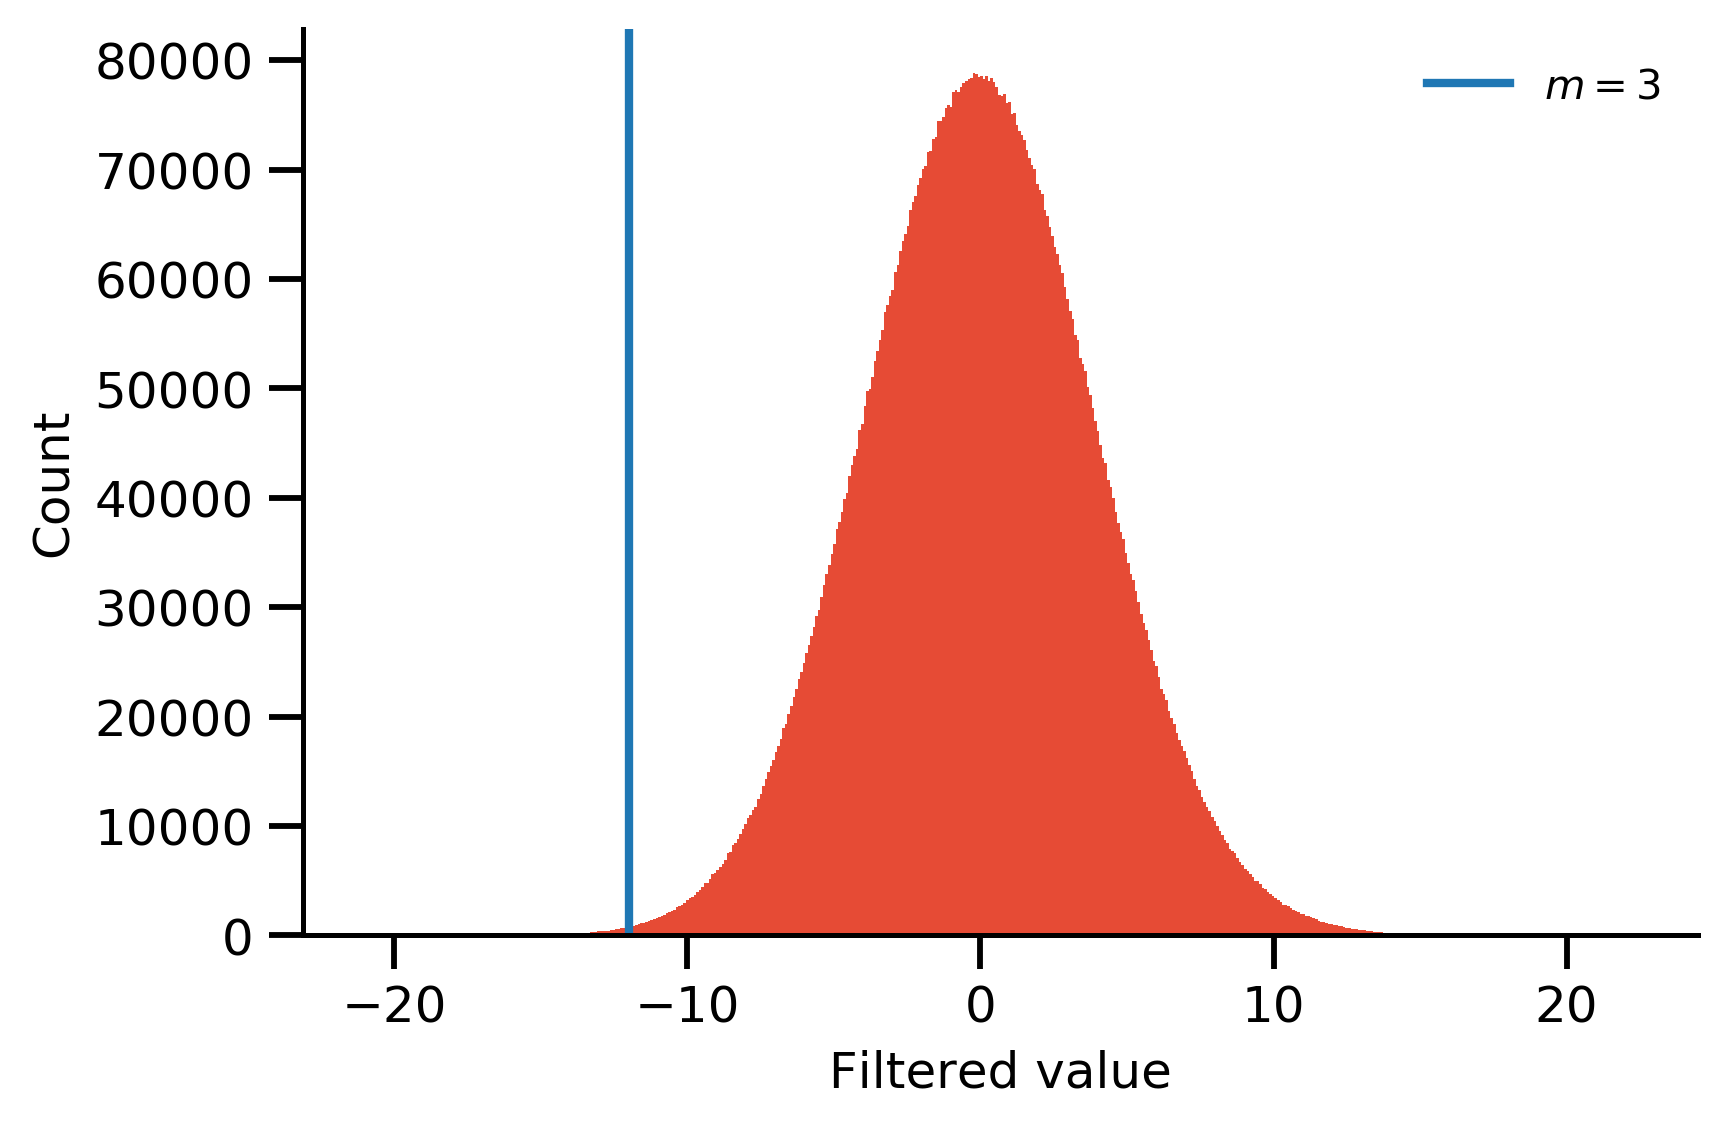

In [18]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, ax = plt.subplots()
    ax.hist(filtered_traces[channel_idx_to_plot, :], bins=500, edgecolor='none')
    channel_std = np.std(filtered_traces[channel_idx_to_plot, :])
    channel_median = np.median(filtered_traces[channel_idx_to_plot, :])
    
    ax.axvline(channel_median - channel_std * multiplier, label='$m=3$')
    
    ax.legend()

    ax.set_xlabel('Filtered value', size=12)
    ax.set_ylabel('Count', size=12)

In [193]:
fig_width = 1000 
fig_height = 300
opts = hv.opts.RGB(width=fig_width, height=fig_height)
datashader_dynamicmap = datashade(hv.Curve((time_in_sec, 
                                             filtered_traces[channel_idx_to_plot, :]),
                                          'Time', 'Filtered value'), 
                 normalization='linear', aggregator=ds.any()).opts(opts)

fig = datashader_dynamicmap

In [194]:
fig

:DynamicMap   []

In [200]:
fig = hv.Curve((time_in_sec, filtered_traces[channel_idx_to_plot, :]),
                'Time', 'Filtered value')


# Compare spatial distribution of spikes before and after TTX

In [94]:
slice_grouped_spike_count

TTX  channel  spikeTime
0    False       12      36260
1    False       13      40210
2    False       14      44784
3    False       15      12297
4    False       16      41248
..     ...      ...        ...
115   True       83          2
116   True       84          2
117   True       85          9
118   True       86      12098
119   True       87          2

[120 rows x 3 columns]

In [95]:
pre_ttx_spike_count = slice_grouped_spike_count.loc[slice_grouped_spike_count['TTX'] == False]['spikeTime'].values
post_ttx_spike_count =  slice_grouped_spike_count.loc[slice_grouped_spike_count['TTX'] == True]['spikeTime'].values

array([12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33,
       34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48, 51, 52, 53, 54,
       55, 56, 57, 58, 61, 62, 63, 64, 65, 66, 67, 68, 71, 72, 73, 74, 75,
       76, 77, 78, 82, 83, 84, 85, 86, 87])

/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/timsit/.conda/envs/mecp2/lib/pyth

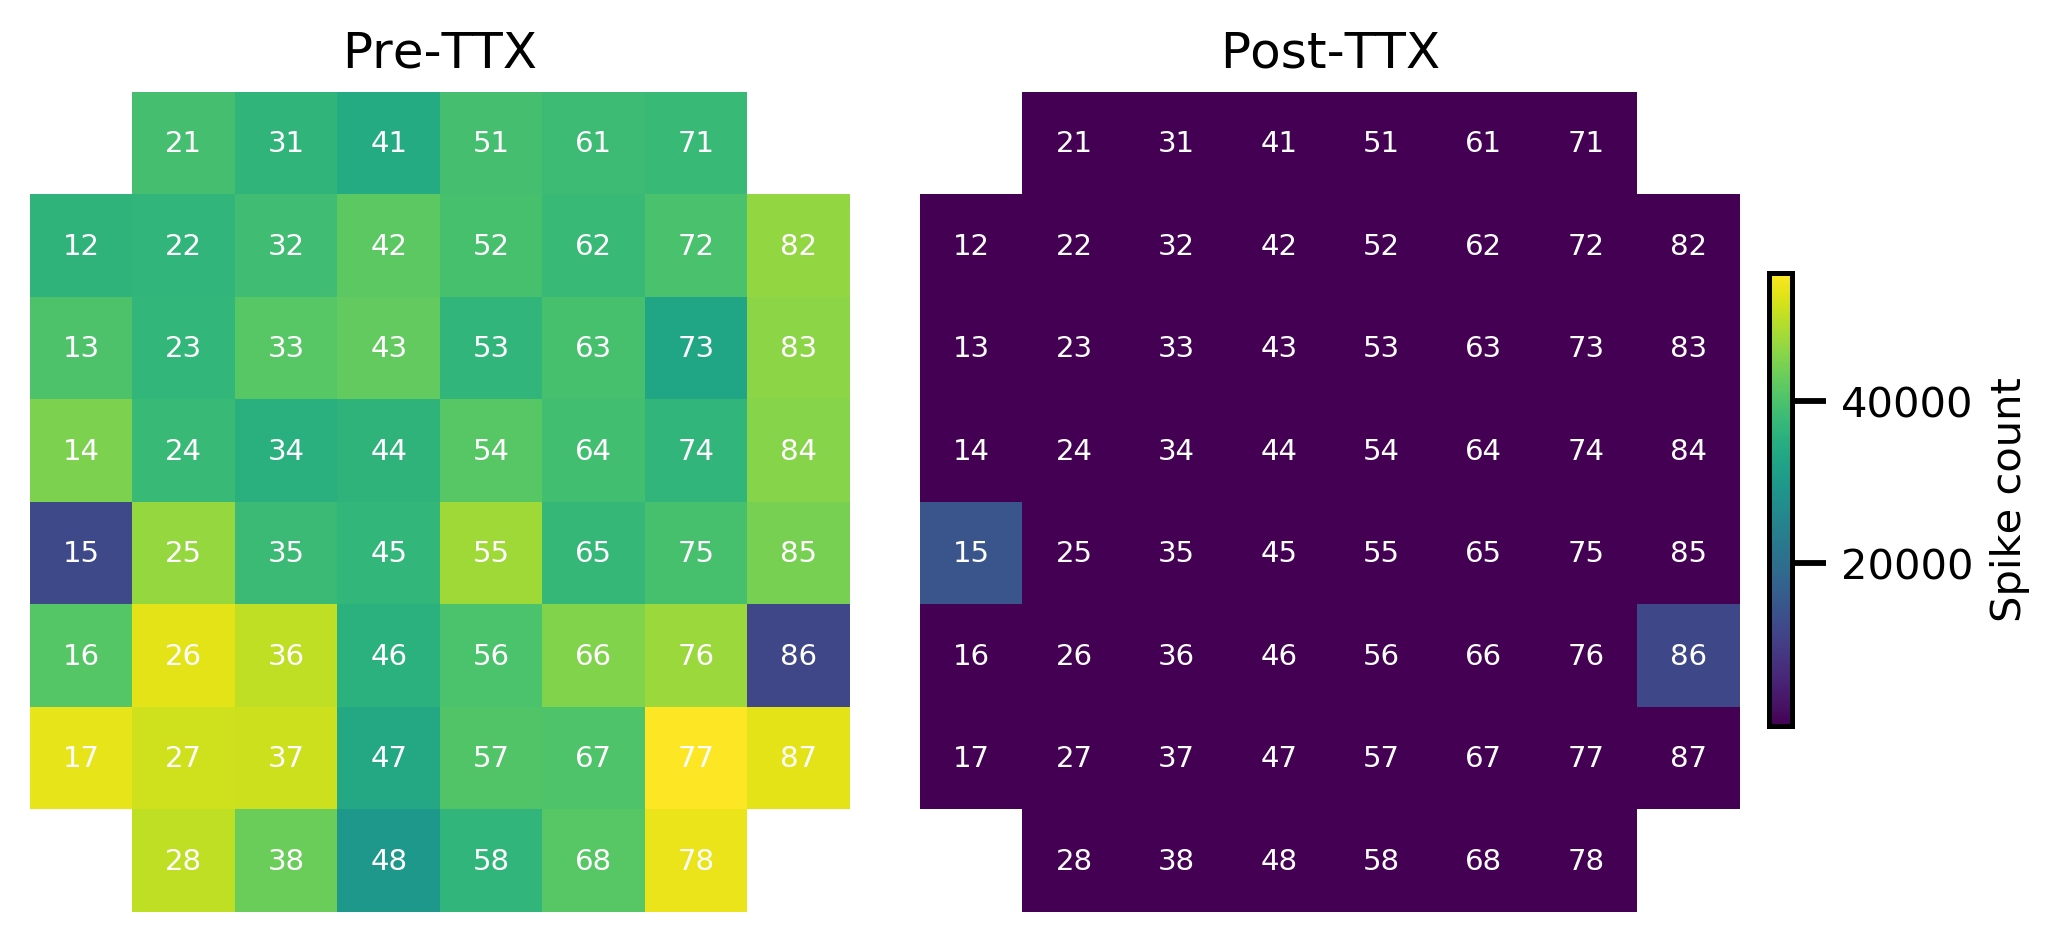

In [96]:
%autoreload
add_electrode_num_text = False

vmin = np.min(np.concatenate([pre_ttx_spike_count, post_ttx_spike_count]))
vmax = np.max(np.concatenate([pre_ttx_spike_count, post_ttx_spike_count]))

with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, axs = plt.subplots(1, 2)
    
    pre_ttx_spike_sum_matrix = mea_util.make_grid_matrix(pre_ttx_spike_count)
    im0 = axs[0].imshow(pre_ttx_spike_sum_matrix, vmin=vmin, vmax=vmax)
    
    # fig.colorbar(ax=axs[0])
    post_ttx_spike_sum_matrix = mea_util.make_grid_matrix(post_ttx_spike_count)
    im1 = axs[1].imshow(post_ttx_spike_sum_matrix, vmin=vmin, vmax=vmax)
    
    axs[0].set_title('Pre-TTX', size=12)
    axs[1].set_title('Post-TTX', size=12)
    
    grid_channel_num_matrix = mea_util.make_grid_matrix(np.unique(slice_grouped_spike_count['channel'].values))
    fig, axs[0] = vizpikes.plot_grid_layout(fig=fig, ax=axs[0], grid_channel_num_matrix=grid_channel_num_matrix,
                                  text_color='white', text_size=7)
    
    fig, axs[1] = vizpikes.plot_grid_layout(fig=fig, ax=axs[1], grid_channel_num_matrix=grid_channel_num_matrix,
                                  text_color='white', text_size=7)
    
    axs[0].axis('off')
    axs[1].axis('off')
    
    cbar = fig.colorbar(im0, ax=axs[:], shrink=0.5, anchor=(2, 0.5))
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label='Spike count', size=10)
    
    fig_folder = '/home/timsit/mecp2/python/figures/spike_detection'
    fig_name = 'MPT200209_3A_DIV_12_spike_count_spyking_circus_pre_vs_post_TTX'
    fig_ext = '.png'
    
    # fig.suptitle('Slice %s on %s', size=12)
    fig.tight_layout()
    # fig.savefig(os.path.join(fig_folder, fig_name), dpi=300, bbox_inches='tight')

# Compare average waveform detected in normal file and TTX file

In [23]:
slice_data_path = '/media/timsit/Seagate Expansion Drive/The_Mecp2_Project/organoid_data/mat/doSpikeDetection/200708_slice1_1.mat'
slice_ttx_data_path = '/media/timsit/Seagate Expansion Drive/The_Mecp2_Project/organoid_data/mat/doSpikeDetection/200708_slice1_1_TTX.mat'

slice_data = mat73.loadmat(slice_data_path)
slice_ttx_data = mat73.loadmat(slice_ttx_data_path)

In [24]:
# filter data 
target_channel_name = 77
channel_idx_in_data = np.where(slice_data['channels'] == target_channel_name)[0]
channel_signal = np.squeeze(slice_data['dat'][:, channel_idx_in_data])

channel_idx_in_ttx_data = np.where(slice_ttx_data['channels'] == target_channel_name)[0]
channel_ttx_signal = np.squeeze(slice_ttx_data['dat'][:, channel_idx_in_ttx_data])

channel_signal_filtered = dspikes.filter_raw_traces([channel_signal])
channel_ttx_signal_filtered = dspikes.filter_raw_traces([channel_ttx_signal])

channel_signal_filtered = channel_signal_filtered.flatten()
channel_ttx_signal_filtered = channel_ttx_signal_filtered.flatten()

In [30]:
time_range

[60, 65]

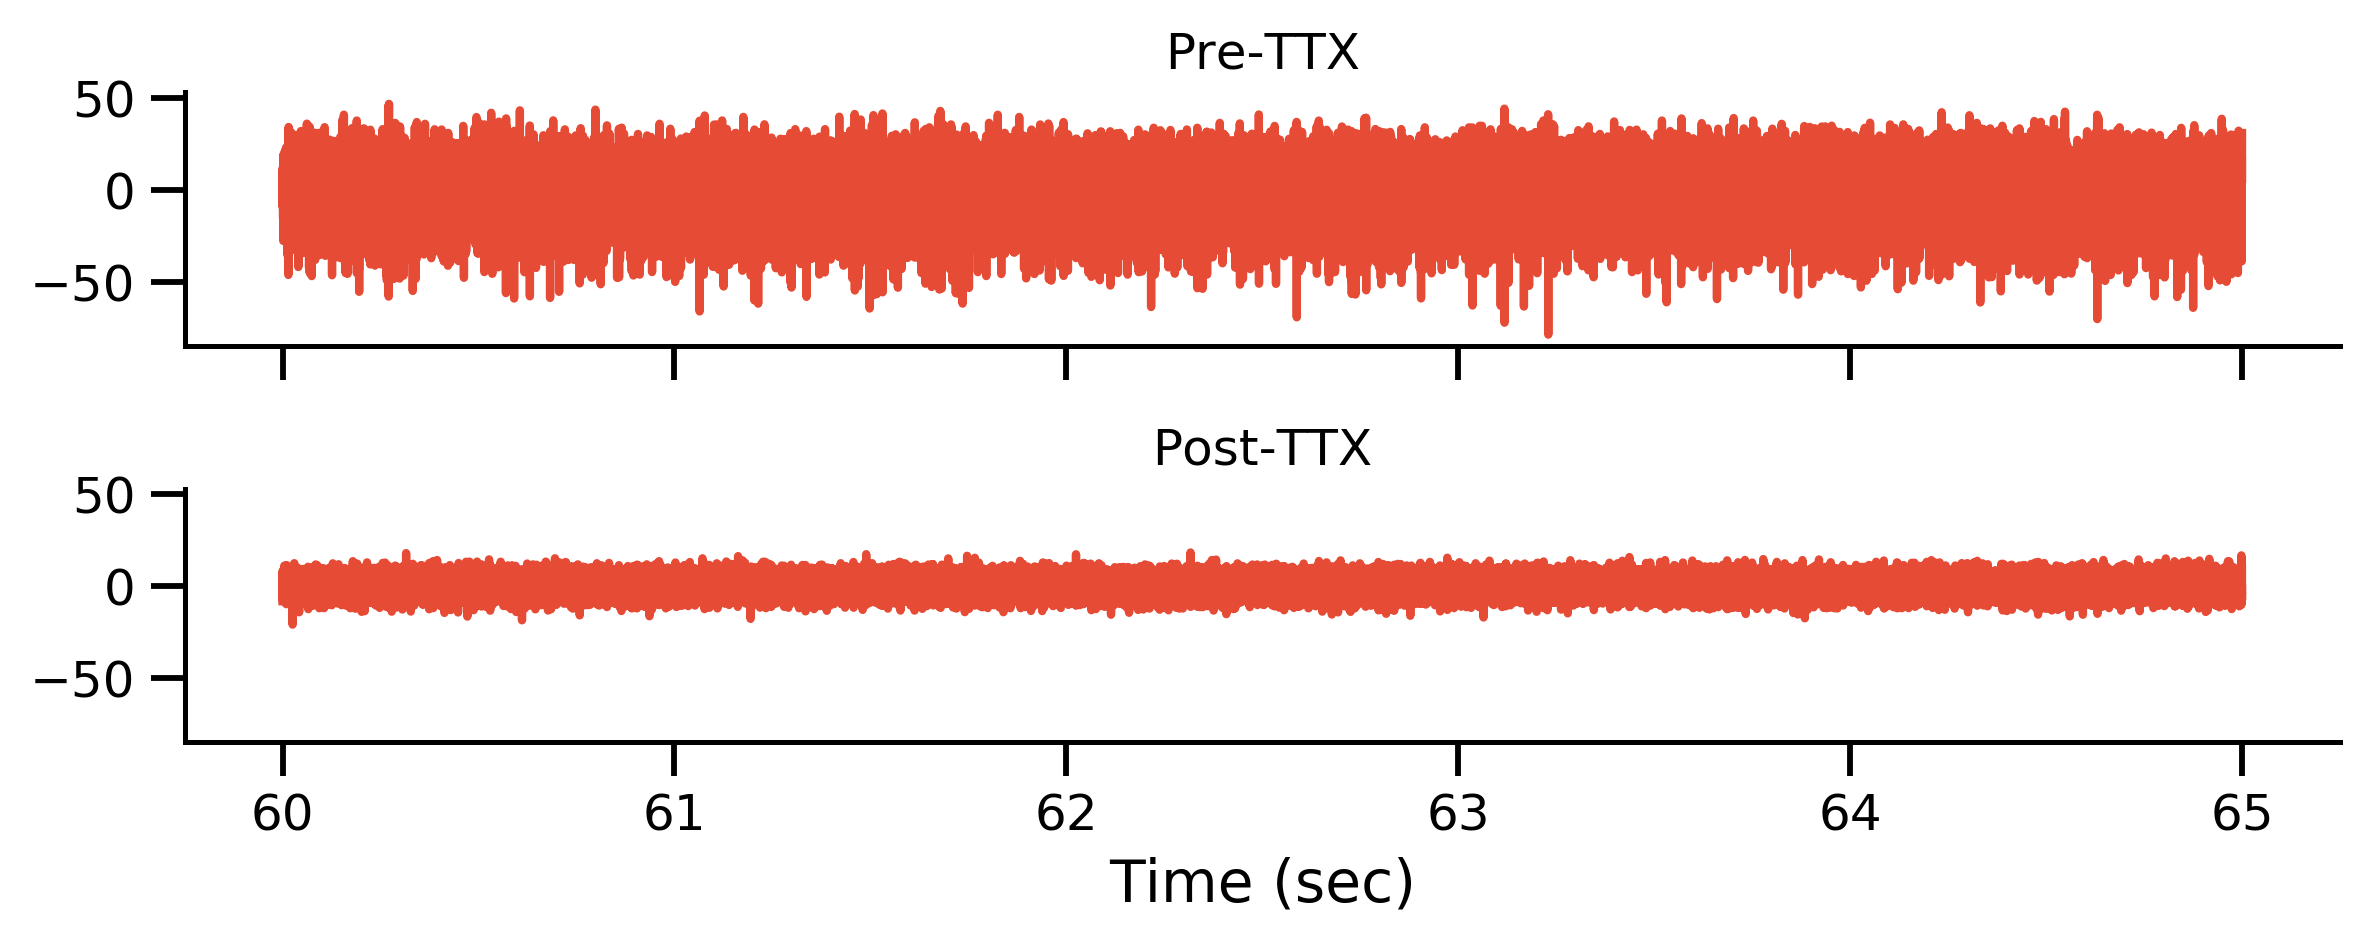

In [31]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fs = 25000
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
    fig.set_size_inches(8, 3)
    
    num_samples = len(channel_signal)
    time_range = np.array([60, 65])
    time_in_sec = np.arange(num_samples) / fs
    time_range_samples = [int(x) for x in time_range * fs]
    time_in_sec_range = time_in_sec[time_range_samples[0]:time_range_samples[1]]

    axs[0].set_title('Pre-TTX', size=12)
    axs[1].set_title('Post-TTX', size=12)
    axs[0].plot(time_in_sec_range, channel_signal_filtered[time_range_samples[0]:time_range_samples[1]])
    axs[1].plot(time_in_sec_range, channel_ttx_signal_filtered[time_range_samples[0]:time_range_samples[1]])
    
    fig.tight_layout()
    
    axs[1].set_xlabel('Time (sec)')
    

In [32]:
def get_spike_waveform(channel_trace, spike_times, time_before_spike=5/1000,
                    time_after_spike=5/1000,
                    fs=25000, ignore_edges=True, peak_align=False, peak_window=[3/1000, 3/1000]):
    
    # spike_time_outside_edges = spike_times[spike_times > time_before_spike]
    num_spikes = len(spike_times)

    num_waveform_samples = int((time_before_spike + time_after_spike) * fs)
    spike_waveform = np.zeros(shape=(num_spikes, int(num_waveform_samples)))

    for n_spike, spike_t in enumerate(spike_times):

        if peak_align:

            time_start_look_for_peak = int((spike_t - peak_window[0]) * fs)
            time_after_look_for_peak = int((spike_t + peak_window[1]) * fs)

            sample_range_to_look_for_peak = np.arange(time_start_look_for_peak,
                                                      time_after_look_for_peak)
            
            trace_to_look_for_peak = channel_trace[sample_range_to_look_for_peak]

            # Find the negative peak
            peak_loc_within_waveform = np.argmin(trace_to_look_for_peak)
            peak_loc_within_trace = sample_range_to_look_for_peak[peak_loc_within_waveform]
            peak_t_within_trace = peak_loc_within_trace / fs

            time_before_spike_sample = int((peak_t_within_trace - time_before_spike) * fs)
            time_after_spike_sample = int((peak_t_within_trace + time_after_spike) * fs)
            
            single_spike_waveform = channel_trace[time_before_spike_sample:time_after_spike_sample]
            
            if len(single_spike_waveform) == num_waveform_samples:
            
                spike_waveform[n_spike, :] = single_spike_waveform

        else:
            
            time_before_spike_sample = int((spike_t - time_before_spike) * fs)
            time_after_spike_sample = int((spike_t + time_after_spike) * fs)
            spike_waveform[n_spike, :] = channel_trace[time_before_spike_sample:time_after_spike_sample]

    return spike_waveform

In [97]:
%autoreload
channel_spike_df = slice_spike_df.loc[(slice_spike_df['channel'] ==target_channel_name) &
                                     (slice_spike_df['TTX'] == False)]

channel_ttx_spike_df = slice_spike_df.loc[(slice_spike_df['channel'] ==target_channel_name) &
                                     (slice_spike_df['TTX'] == True)]

channel_spike_waveform = get_spike_waveform(channel_trace=channel_signal_filtered,
                                                     spike_times=channel_spike_df['spikeTime'].values,
                                           peak_align=True)
channel_ttx_spike_waveform = get_spike_waveform(channel_trace=channel_ttx_signal_filtered,
                                                     spike_times=channel_ttx_spike_df['spikeTime'].values,
                                            peak_align=True)



In [106]:
np.shape(subset_channel_spike_waveform)

(250, 43683)

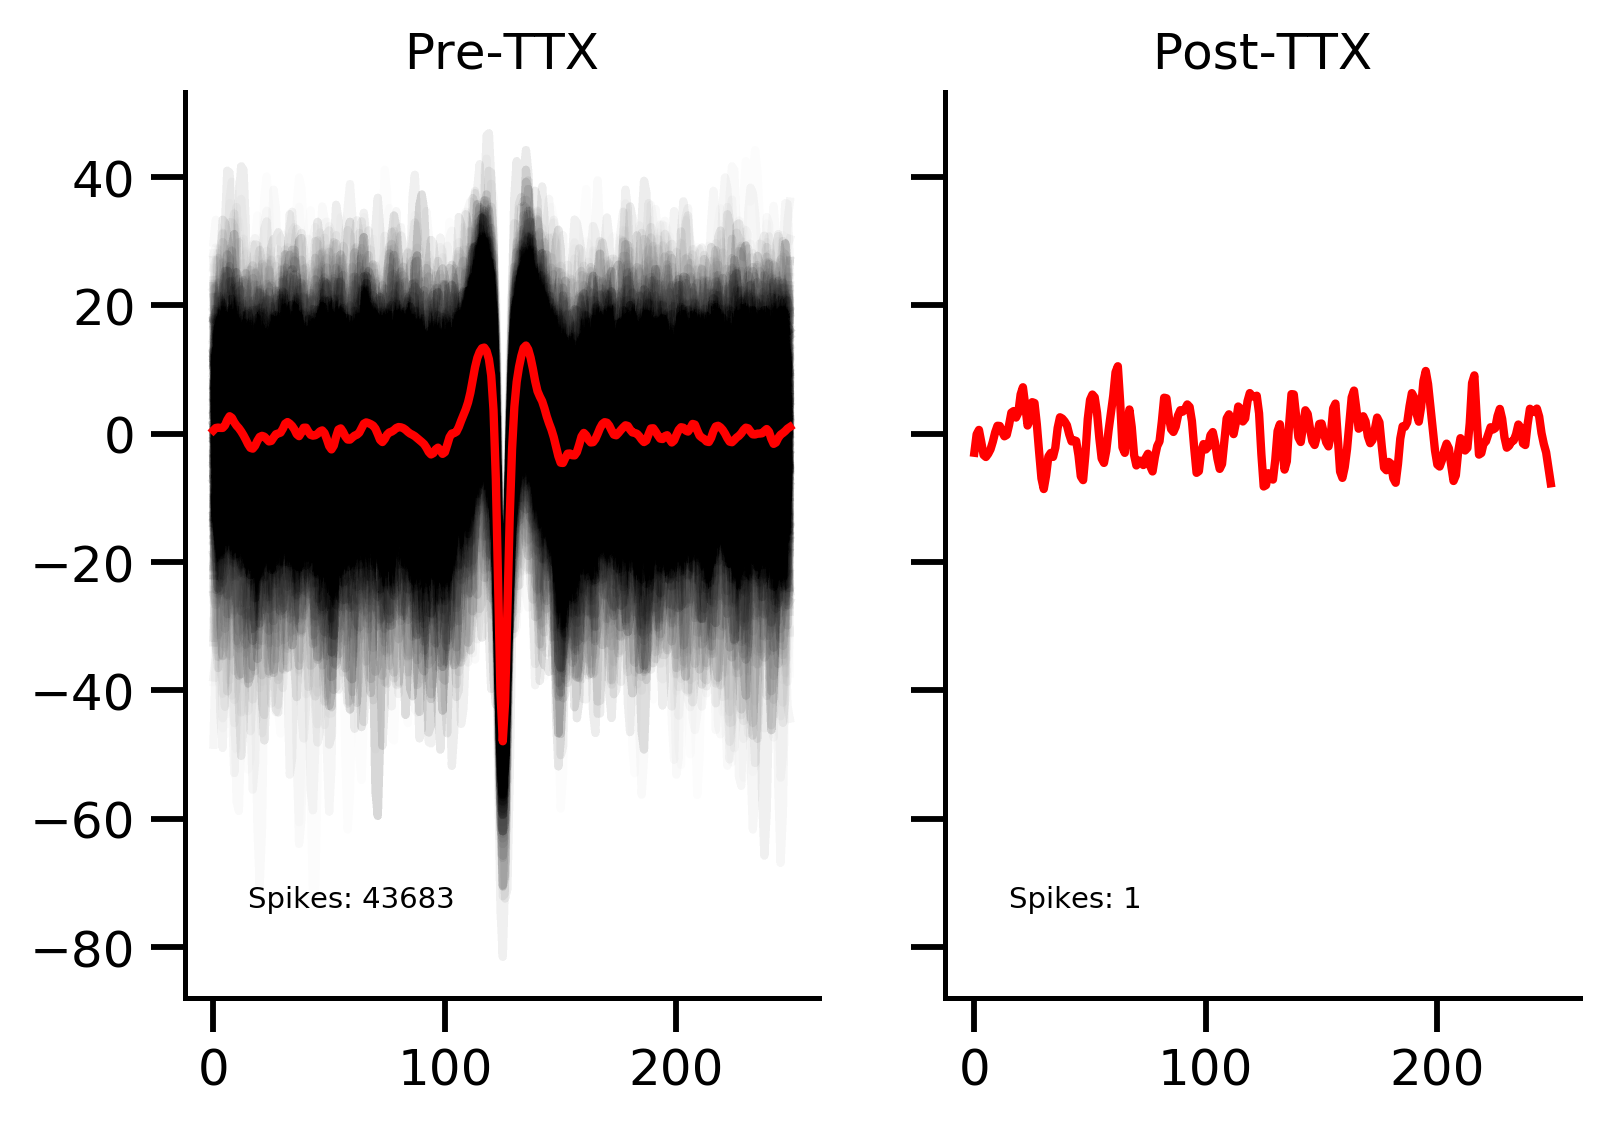

In [107]:
max_neg_deflection = 1000
min_neg_deflection = 1
max_spikes_to_plot = 1000

with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, axs = plt.subplots(1, 2, sharey=True)
    axs[0].set_title('Pre-TTX', size=12)
    axs[1].set_title('Post-TTX', size=12)
    
   
    
    if max_neg_deflection is not None:
        
        spike_amplitude = np.min(channel_spike_waveform.T, axis=0)
        subset_spike_idx = np.where(
            (np.abs(spike_amplitude) <= max_neg_deflection) &
            (np.abs(spike_amplitude) >= min_neg_deflection)
            )[0]
        
        # subset_spike_idx = subset_spike_idx[:max_spikes_to_plot]
        
        subset_channel_spike_waveform = channel_spike_waveform.T[:, subset_spike_idx]
        
        axs[0].plot(subset_channel_spike_waveform[:, 0:max_spikes_to_plot], color='black', alpha=0.01)
        axs[0].plot(np.mean(subset_channle_spike_waveform, axis=1), color='red', alpha=1)
        axs[0].text(0.1, 0.1, 'Spikes: %.f' % np.shape(subset_channel_spike_waveform)[1], transform=axs[0].transAxes, size=7)

        
        spike_amplitude = np.min(channel_ttx_spike_waveform.T, axis=0)
        subset_spike_idx = np.where(
            (np.abs(spike_amplitude) <= max_neg_deflection) &
            (np.abs(spike_amplitude) >= min_neg_deflection)
            )[0]
        
        subset_spike_idx = subset_spike_idx[:max_spikes_to_plot]
        
        subset_channel_TTX_spike_waveform = channel_ttx_spike_waveform.T[:, subset_spike_idx]
        axs[1].plot(subset_channel_TTX_spike_waveform, color='black', alpha=0.01)
        axs[1].plot(np.mean(subset_channel_TTX_spike_waveform, axis=1), color='red', alpha=1)
        axs[1].text(0.1, 0.1, 'Spikes: %.f' % np.shape(subset_channel_TTX_spike_waveform)[1], 
                    transform=axs[1].transAxes, size=7)
        
    else:
    
        axs[0].plot(channel_spike_waveform.T, color='black', alpha=0.01)
        axs[0].plot(np.mean(channel_spike_waveform, axis=0), color='red', alpha=1)
        axs[0].text(0.1, 0.1, 'Spikes: %.f' % np.shape(channel_spike_waveform.T)[1], transform=axs[0].transAxes, size=7)

        axs[1].plot(channel_ttx_spike_waveform.T, color='black', alpha=0.01)
        axs[1].plot(np.mean(channel_ttx_spike_waveform, axis=0), color='red', alpha=1)
        axs[1].text(0.1, 0.1, 'Spikes: %.f' % np.shape(channel_ttx_spike_waveform.T)[1], 
                    transform=axs[1].transAxes, size=7)
    
    
    
    fig_folder = ''

### Look at amplitude distribution of spike waveforms

In [109]:
np.shape(subset_channel_spike_waveform)

(250, 43683)

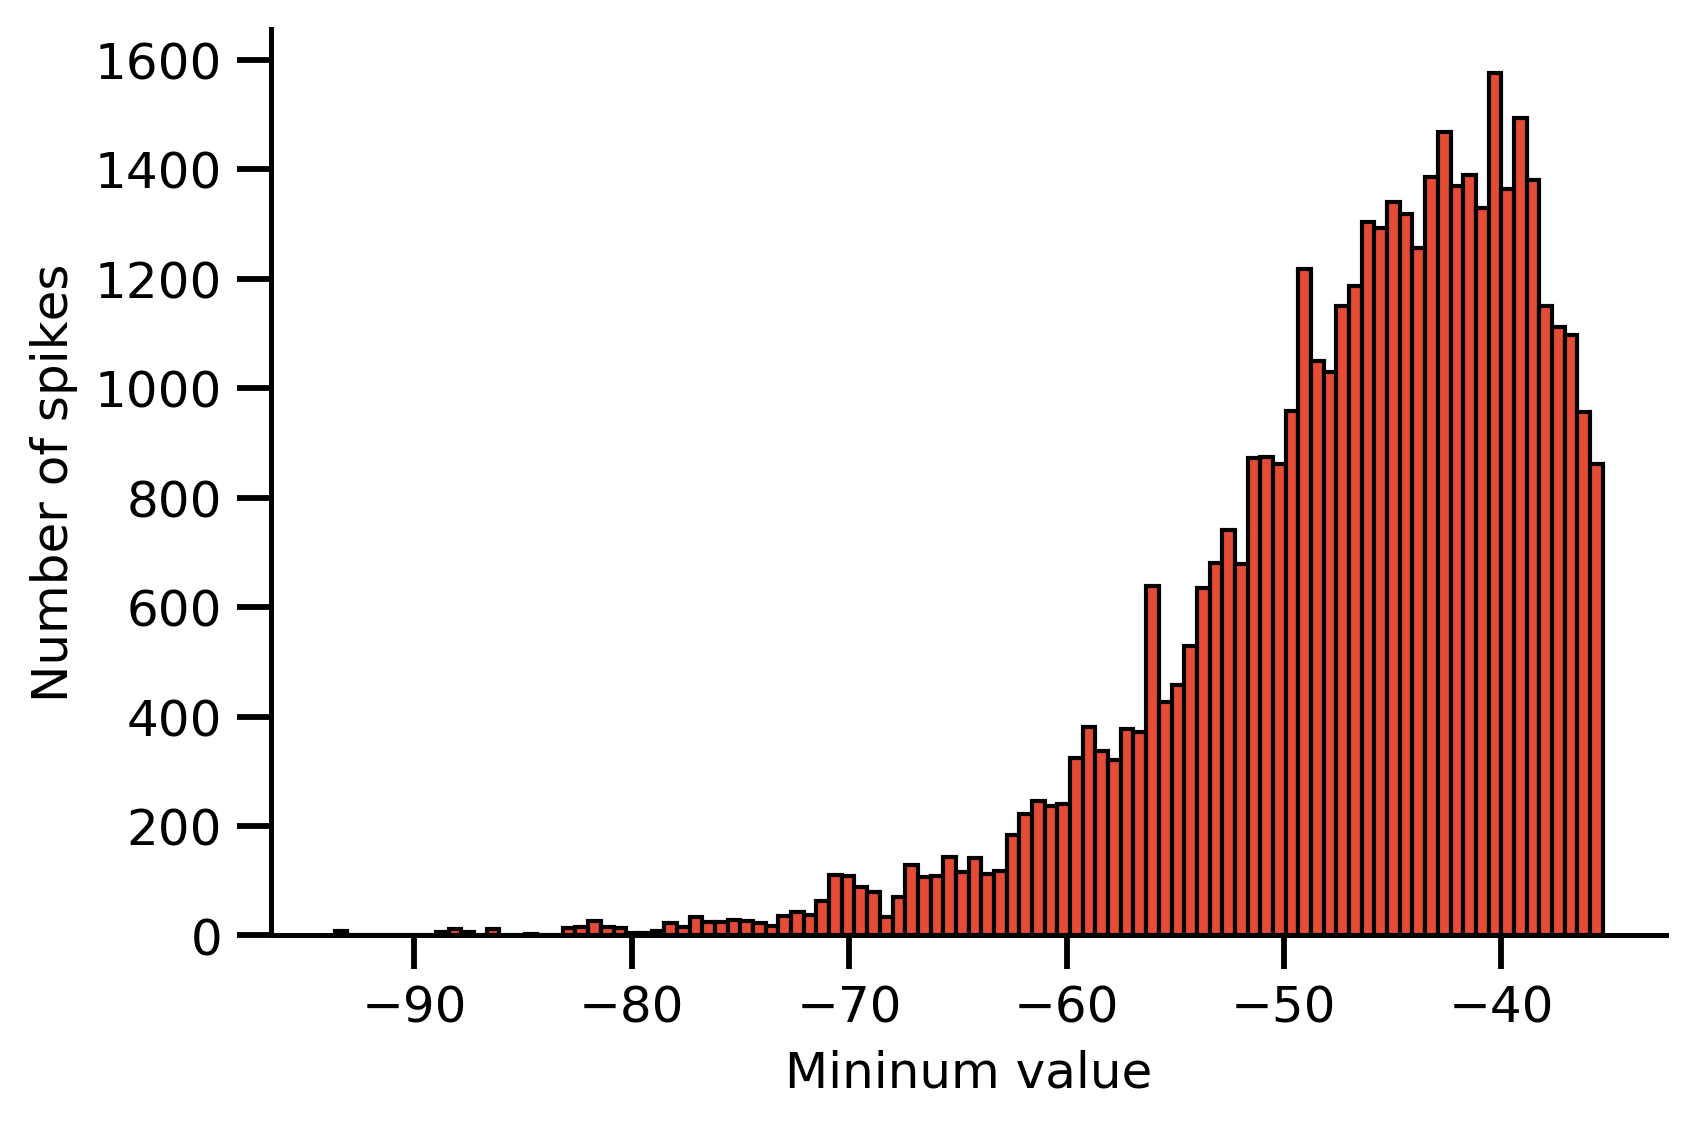

In [110]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, ax = plt.subplots()
    spike_amplitude = np.min(subset_channel_spike_waveform, axis=0)
    ax.hist(spike_amplitude, bins=100)
    
    ax.set_xlabel('Mininum value', size=12)
    ax.set_ylabel('Number of spikes', size=12)

# Parameter search for L parameter

In [57]:
spike_counts_per_L = all_file_spike_df.groupby(['TTX', 'L']).agg('count')['spikeTime'].reset_index()

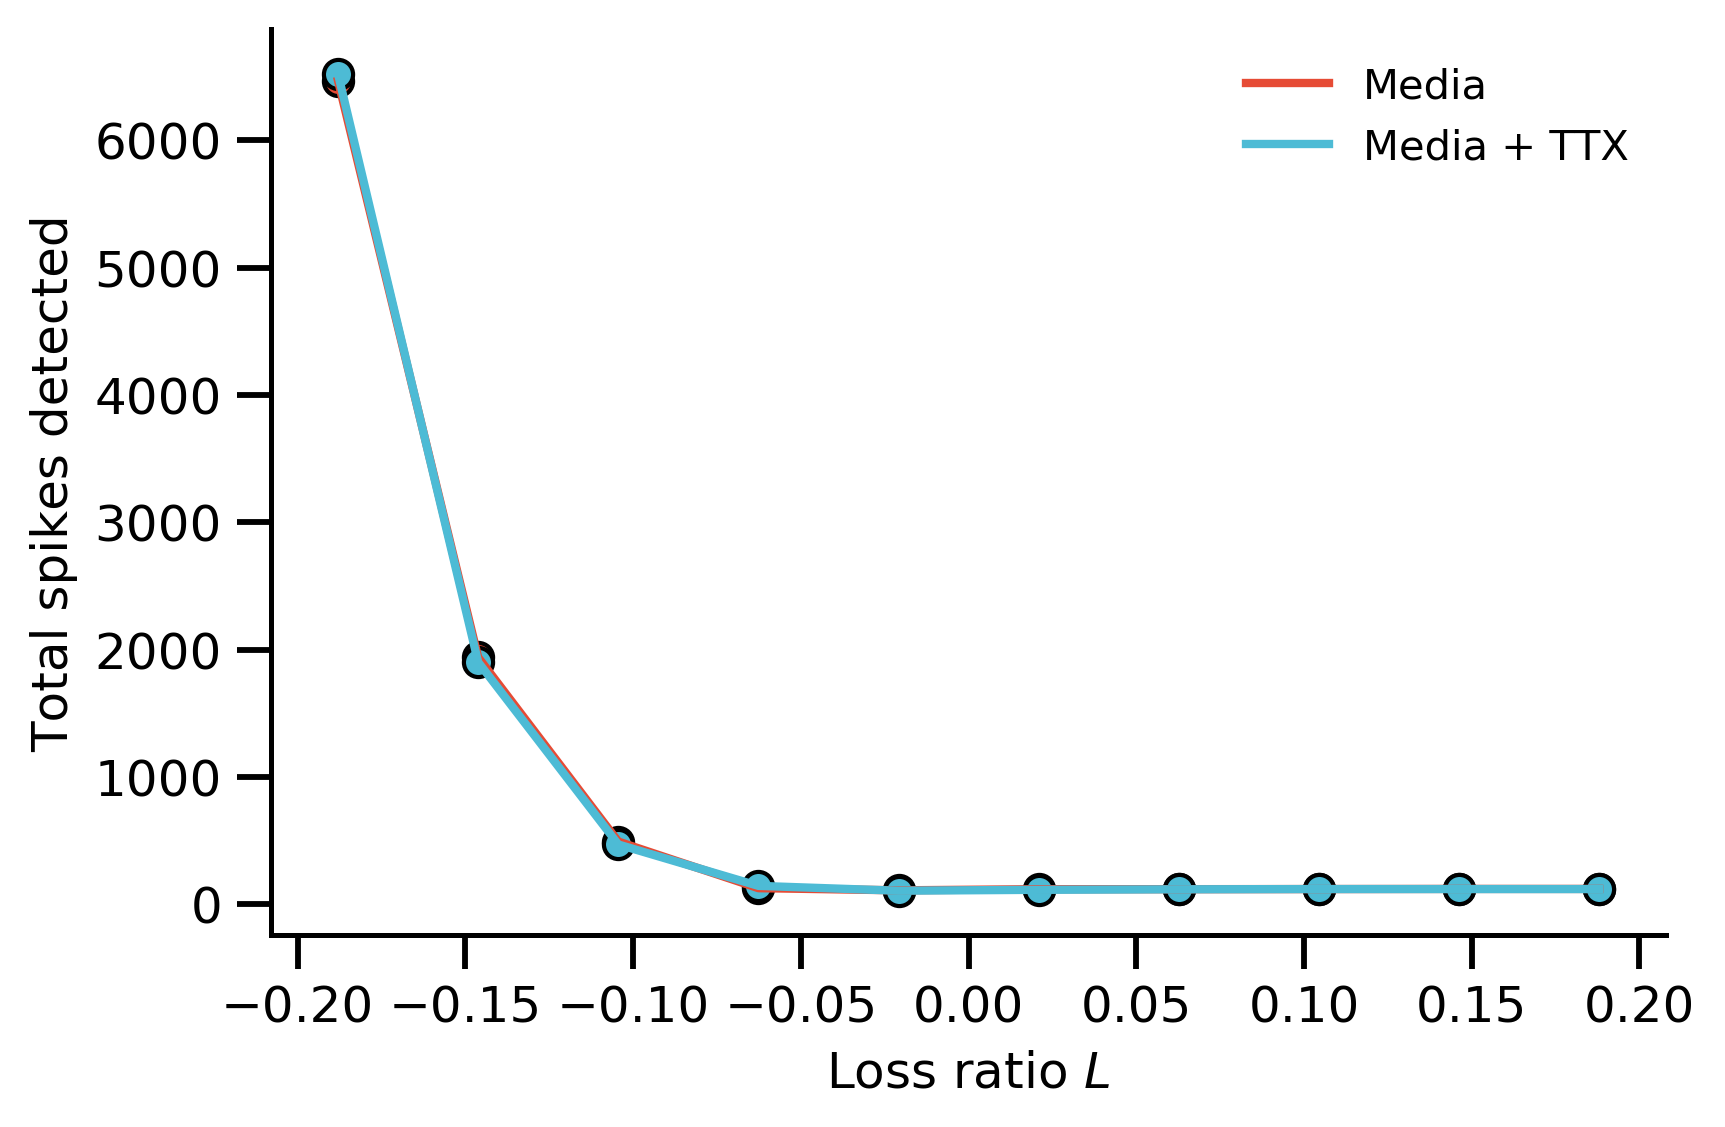

In [58]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, ax = plt.subplots()
    
    
    ax.plot(spike_counts_per_L.loc[spike_counts_per_L['TTX'] == False]['L'], 
            spike_counts_per_L.loc[spike_counts_per_L['TTX'] == False]['spikeTime'],
            label='Media')

    ax.scatter(spike_counts_per_L.loc[spike_counts_per_L['TTX'] == False]['L'], 
            spike_counts_per_L.loc[spike_counts_per_L['TTX'] == False]['spikeTime'])

    ax.plot(spike_counts_per_L.loc[spike_counts_per_L['TTX'] == True]['L'], 
            spike_counts_per_L.loc[spike_counts_per_L['TTX'] == True]['spikeTime'],
            label='Media + TTX')

    ax.scatter(spike_counts_per_L.loc[spike_counts_per_L['TTX'] == True]['L'], 
            spike_counts_per_L.loc[spike_counts_per_L['TTX'] == True]['spikeTime'])
    
    
    ax.set_xlabel('Loss ratio $L$', size=12)
    ax.set_ylabel('Total spikes detected', size=12)
    
    ax.legend()

### Loop over each organoid and make this plot

In [64]:
all_file_spike_df

channel spikeTime  slice_number recording_date    TTX         L
0         12   51.9482             1         200617  False -0.020889
1         13         0             1         200617  False -0.020889
2         13         0             1         200617  False -0.020889
3         14   3.85576             1         200617  False -0.020889
4         15         0             1         200617  False -0.020889
..       ...       ...           ...            ...    ...       ...
115       85         0             3         200708   True  0.188000
116       86         0             3         200708   True  0.188000
117       86         0             3         200708   True  0.188000
118       87         0             3         200708   True  0.188000
119       87         0             3         200708   True  0.188000

[238598 rows x 6 columns]

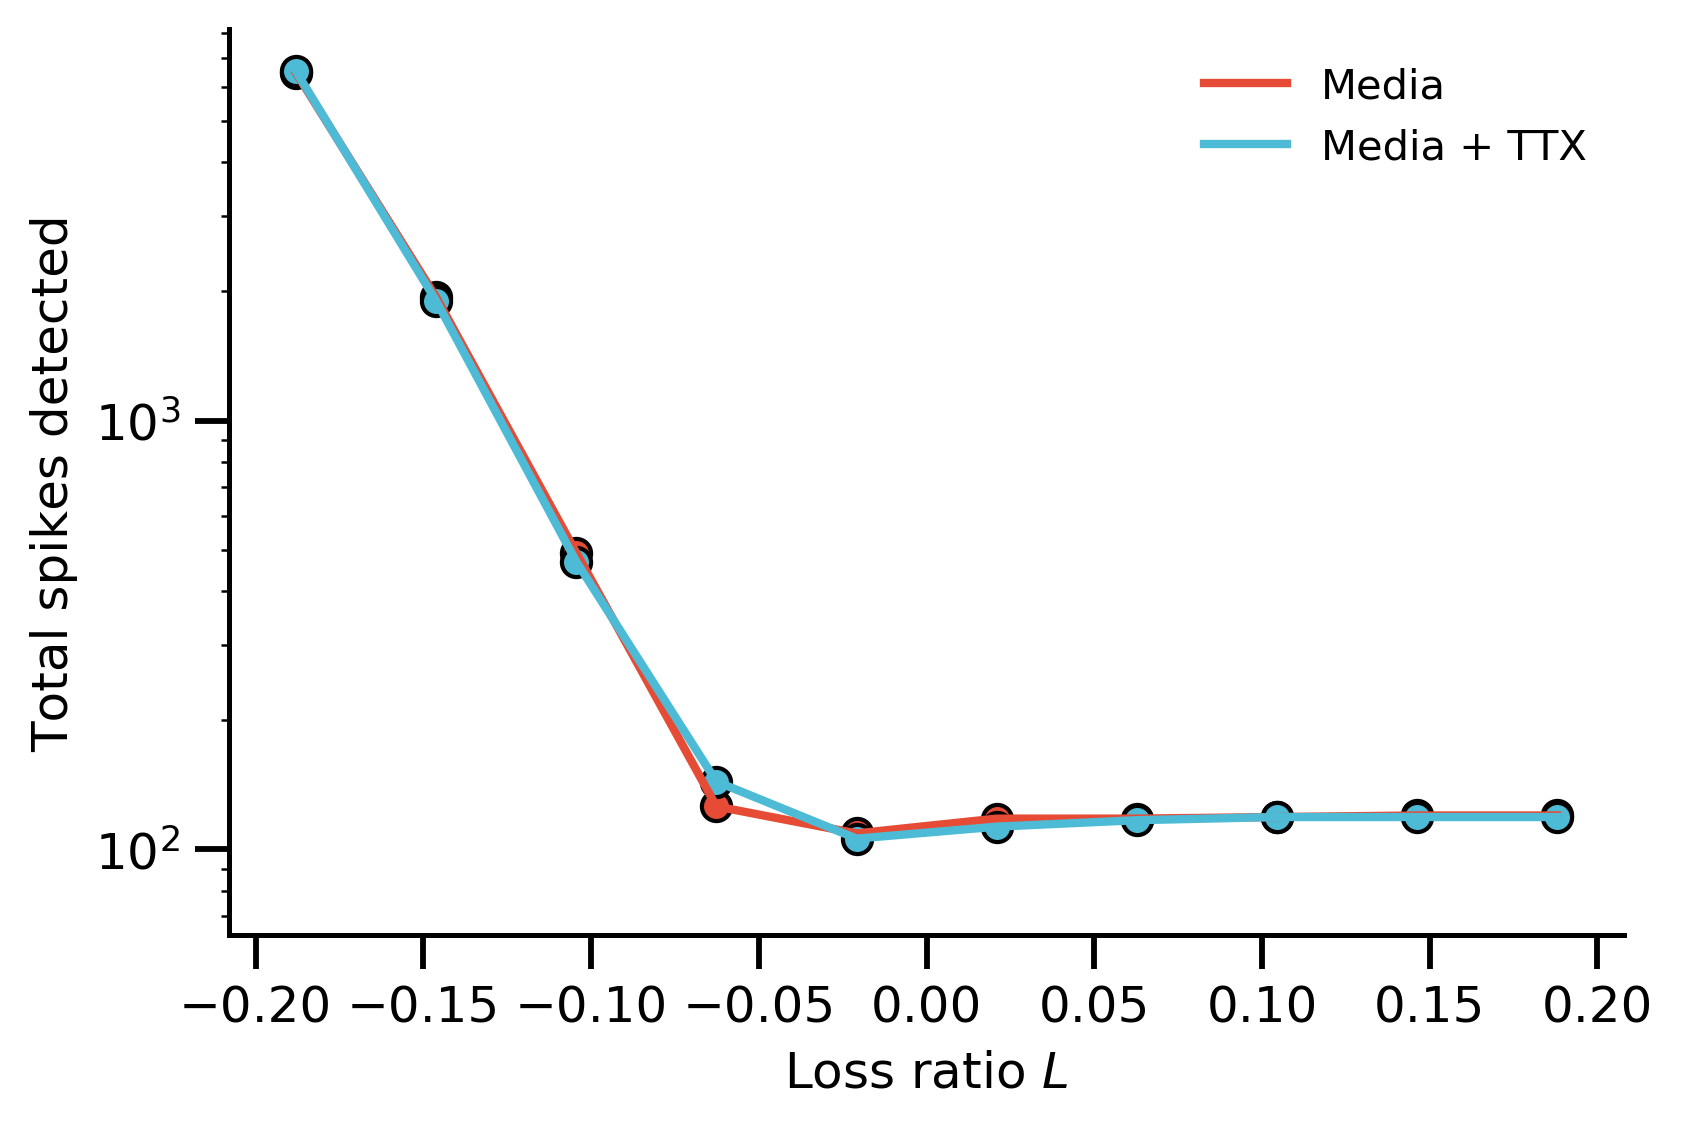

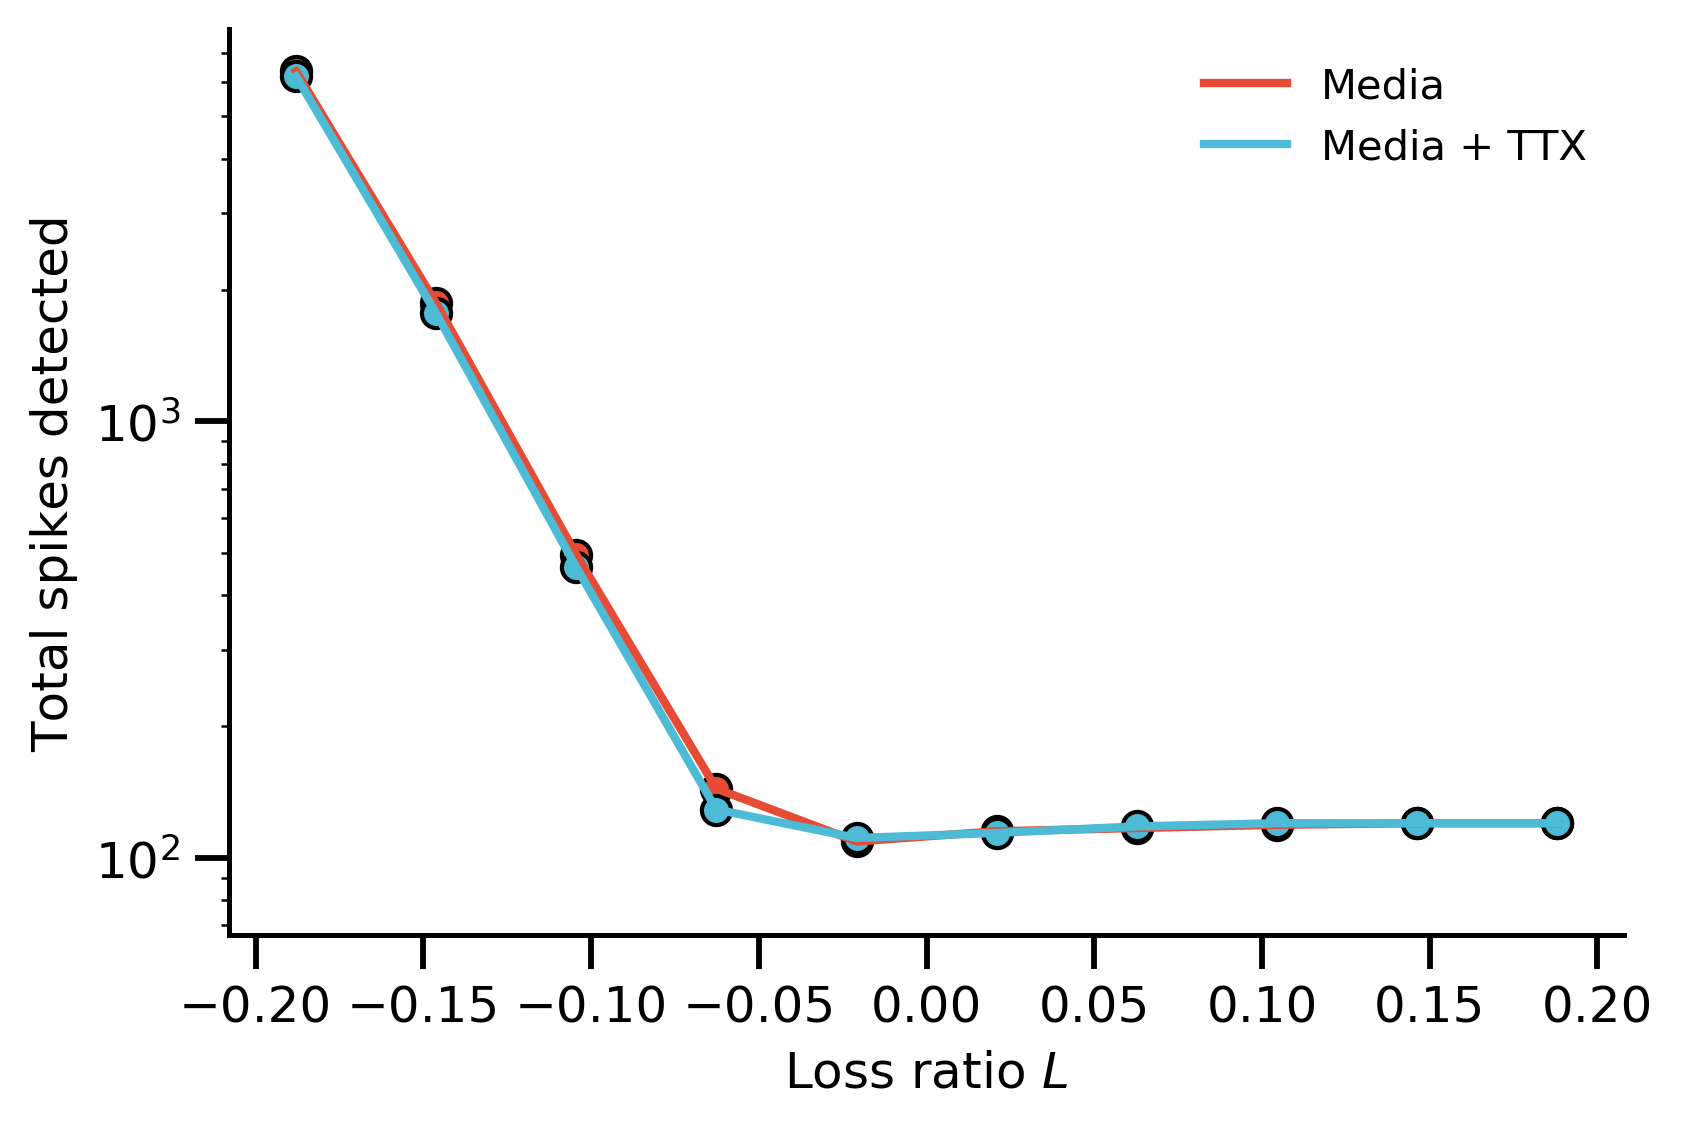

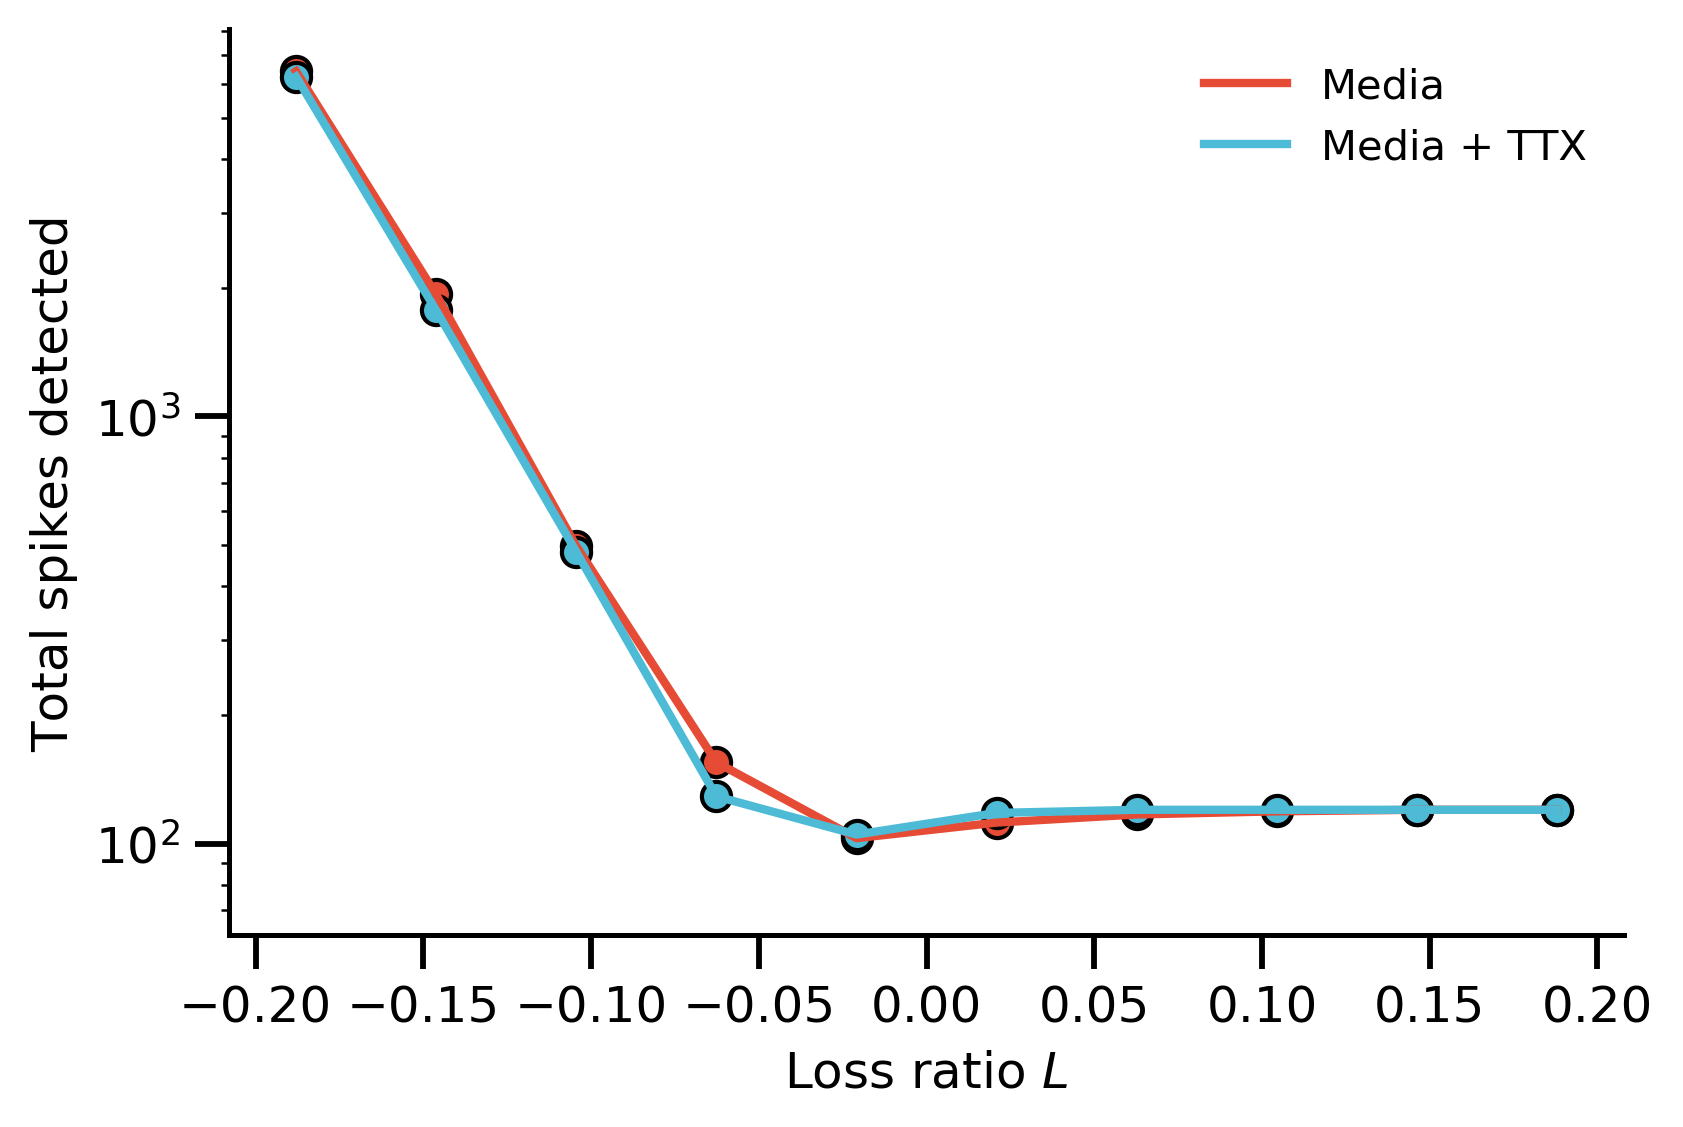

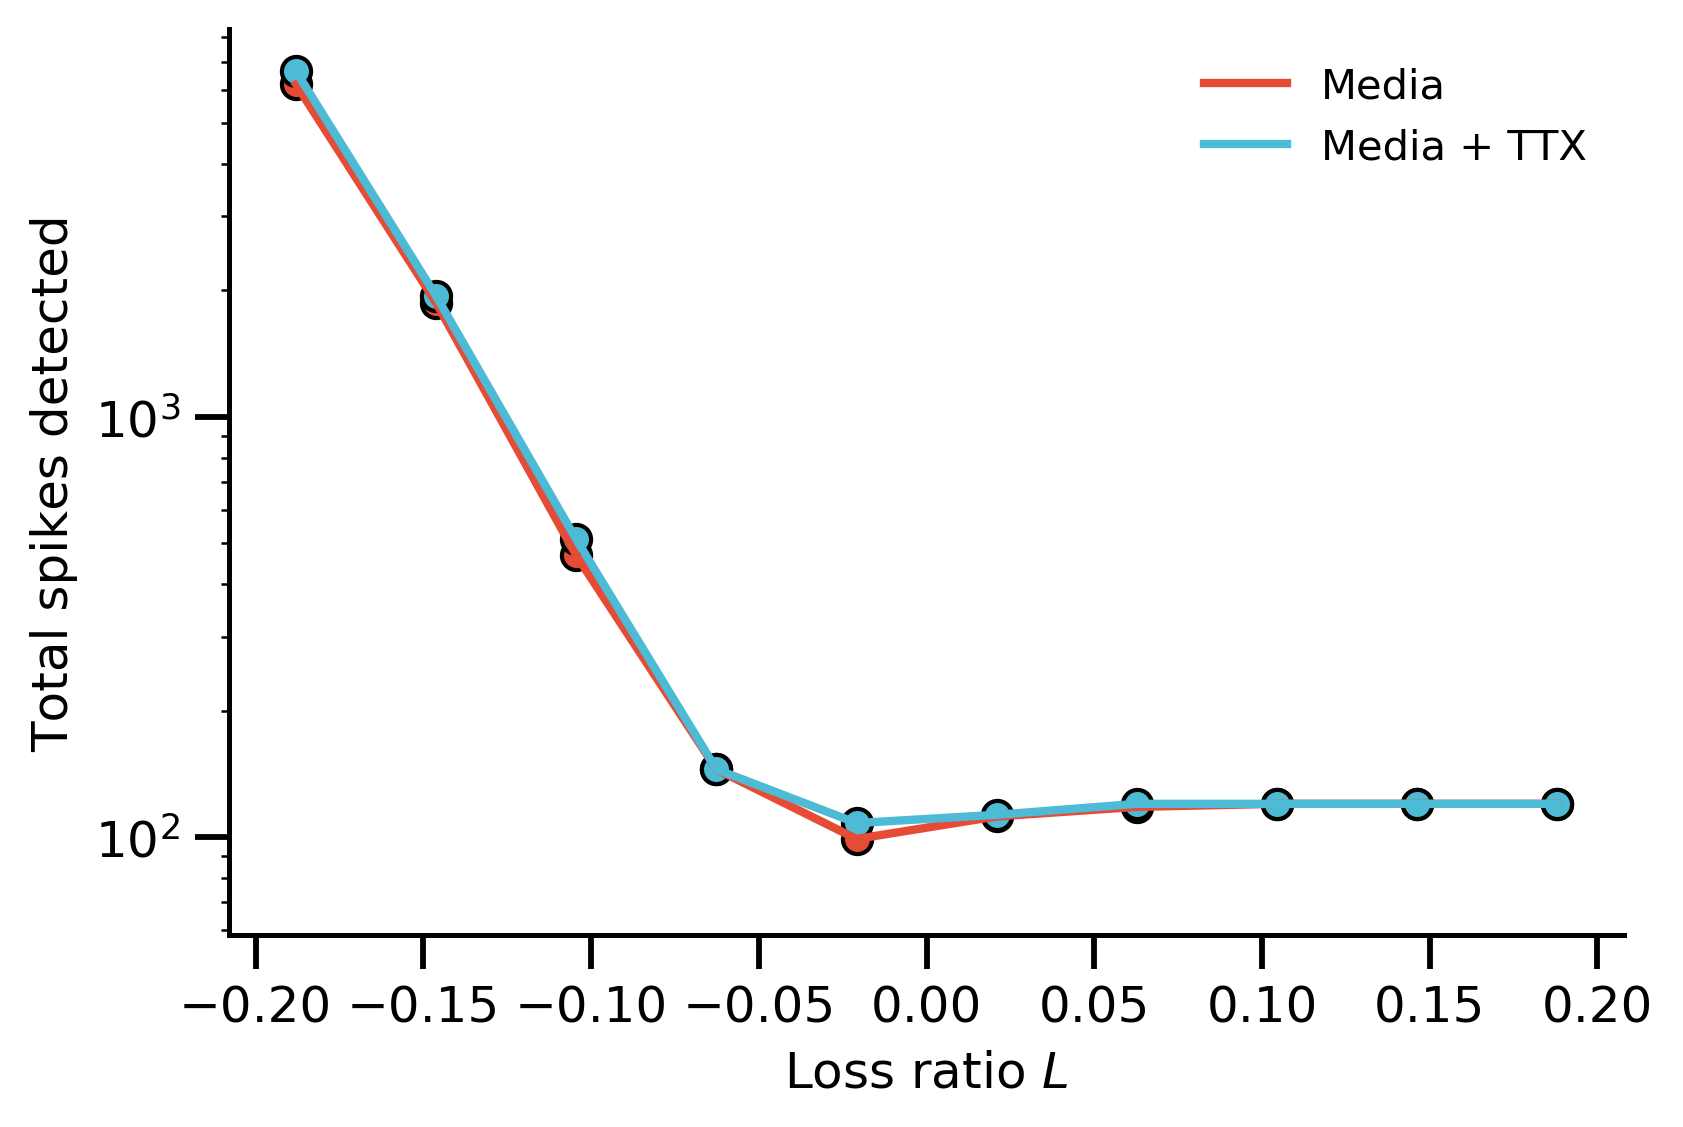

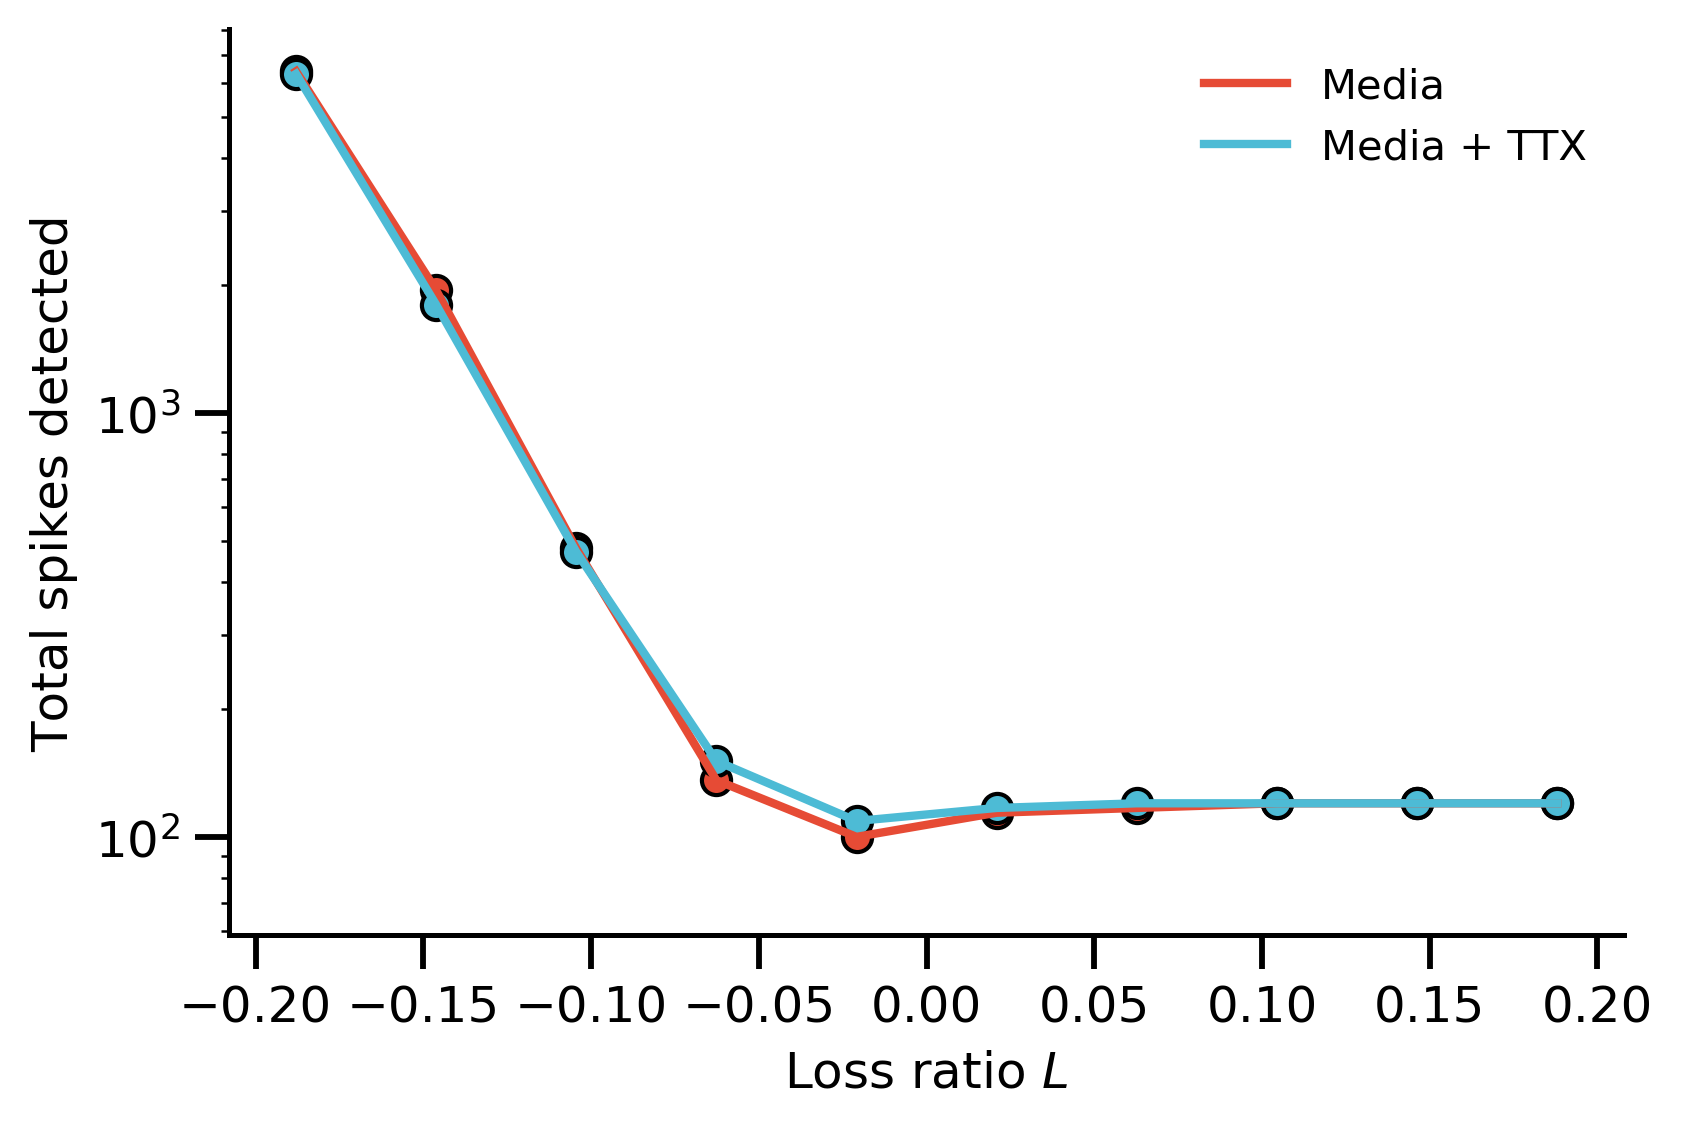

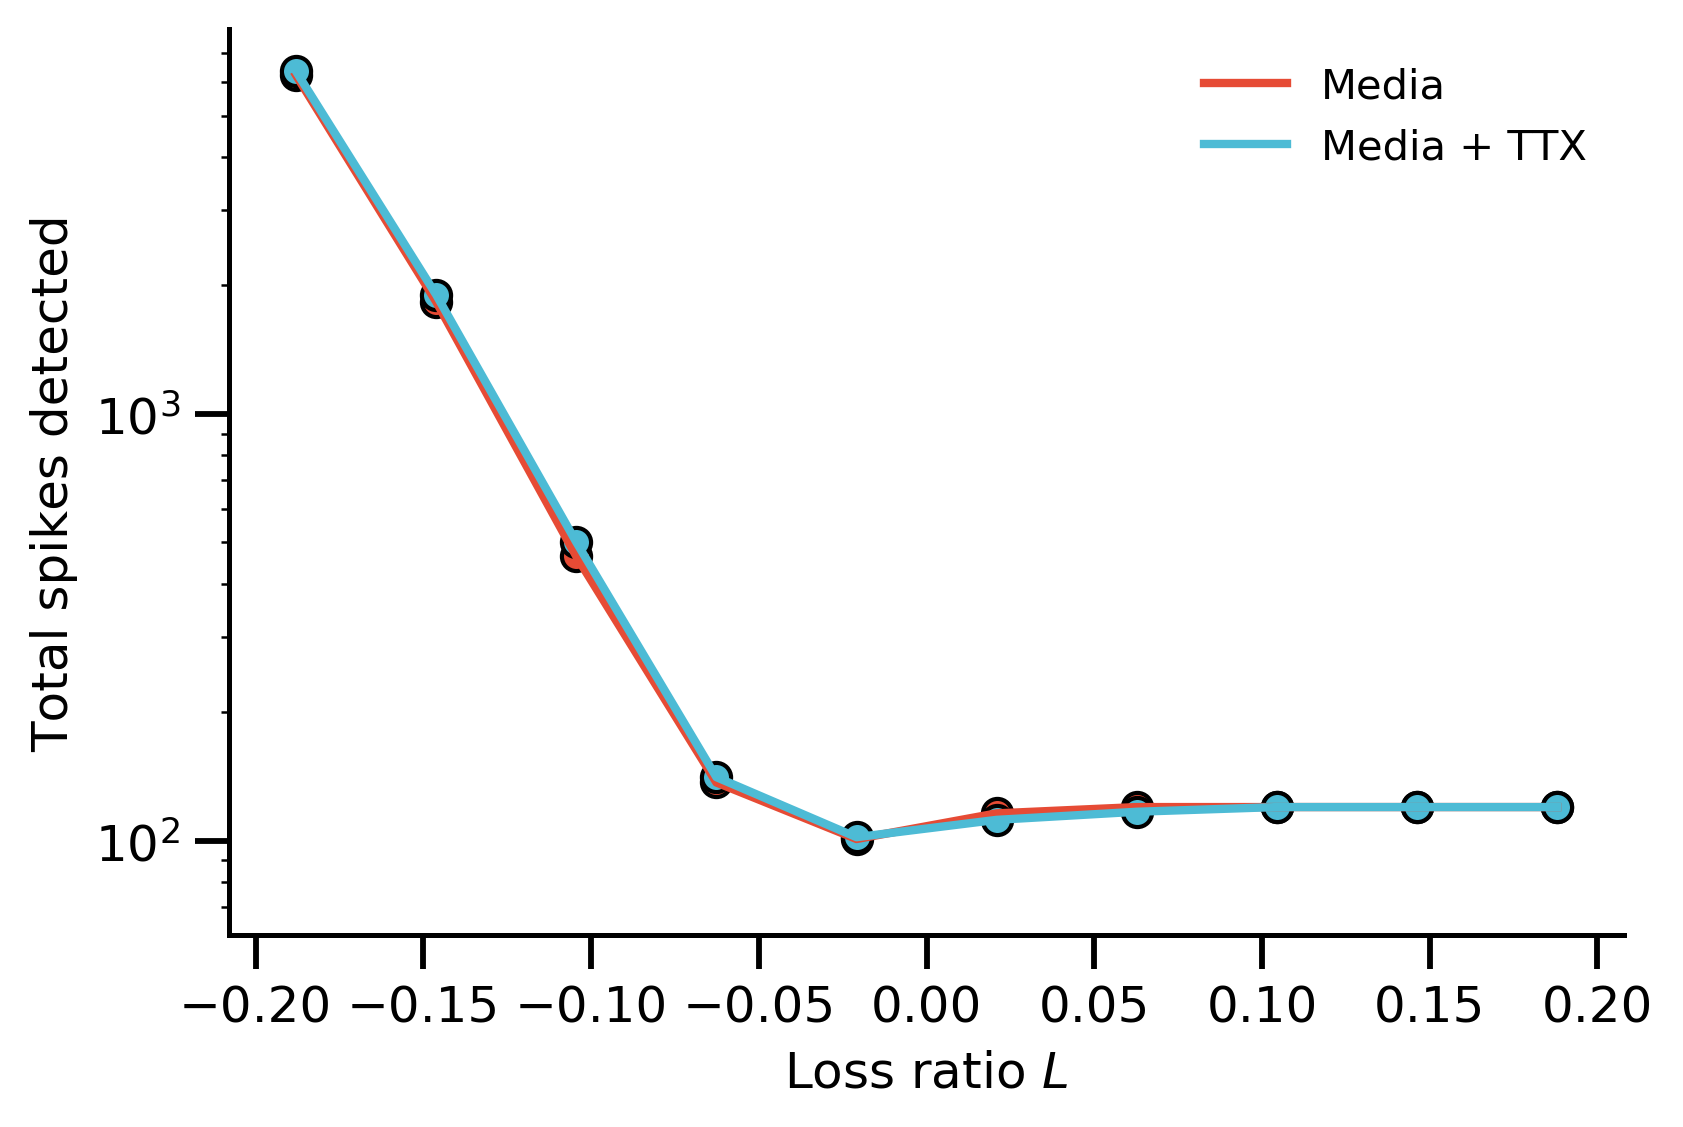

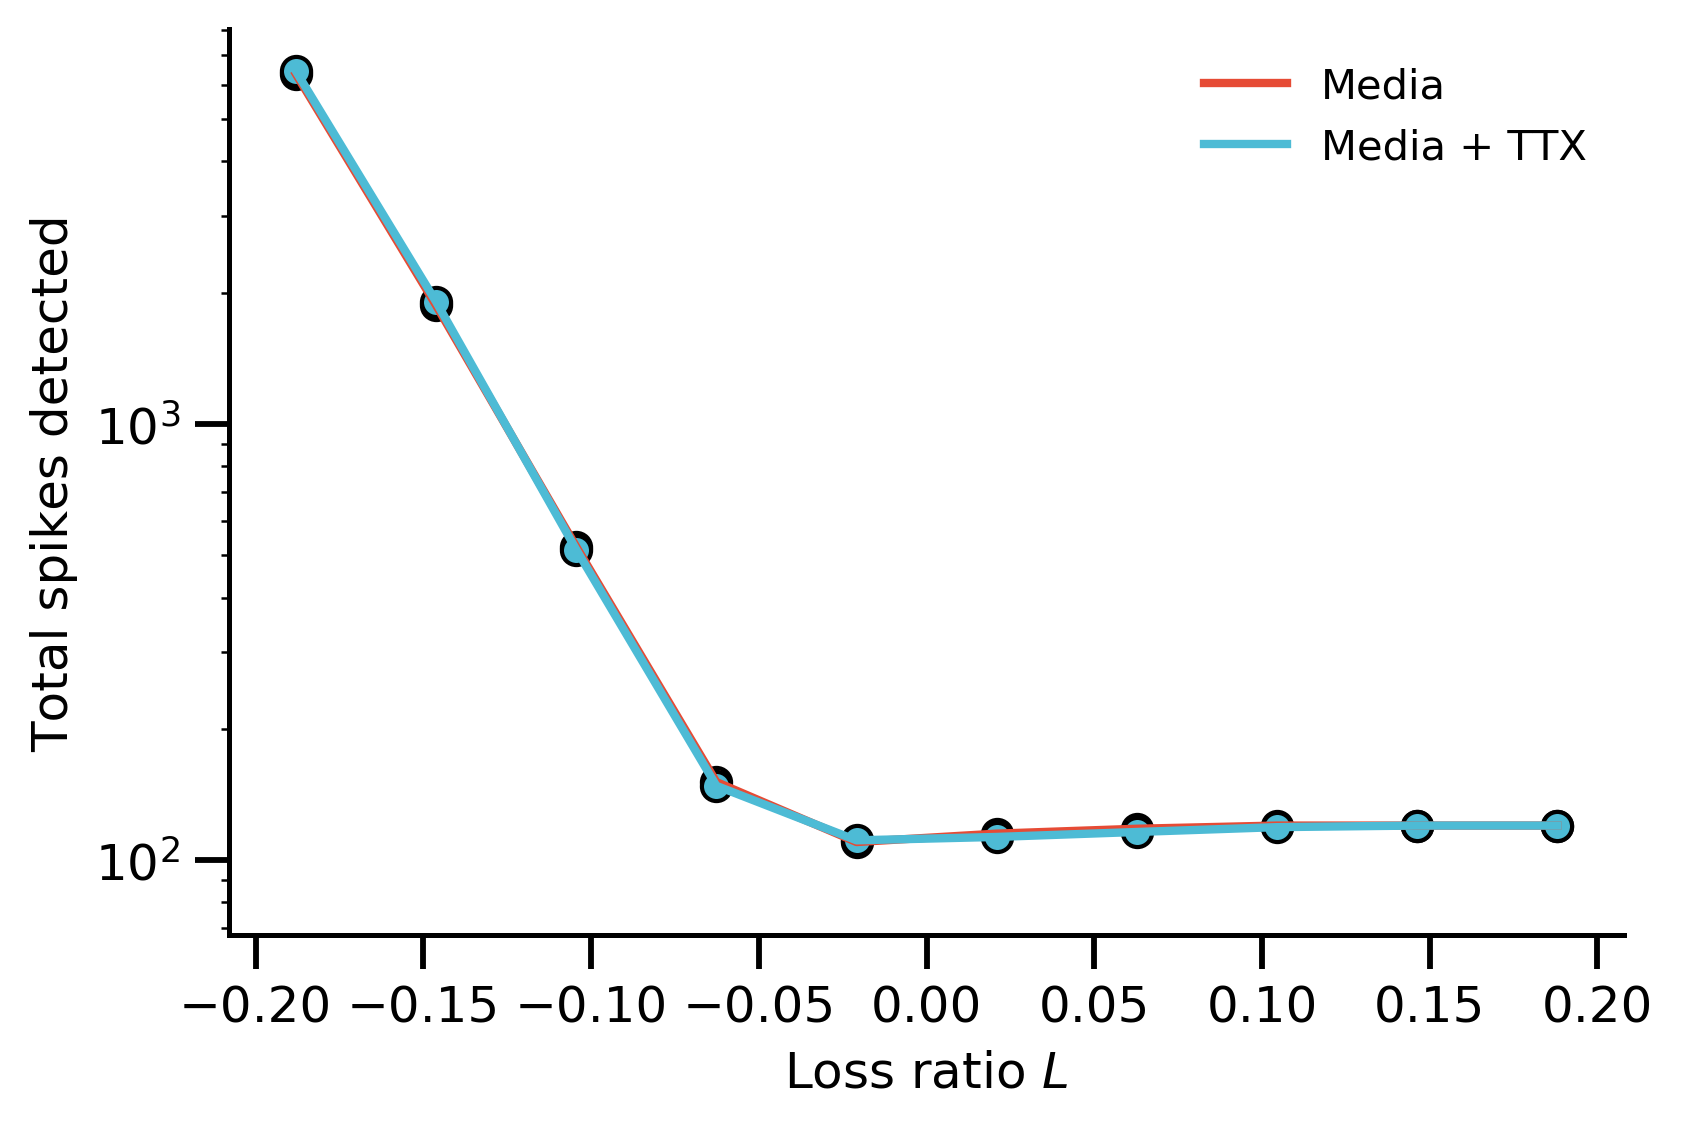

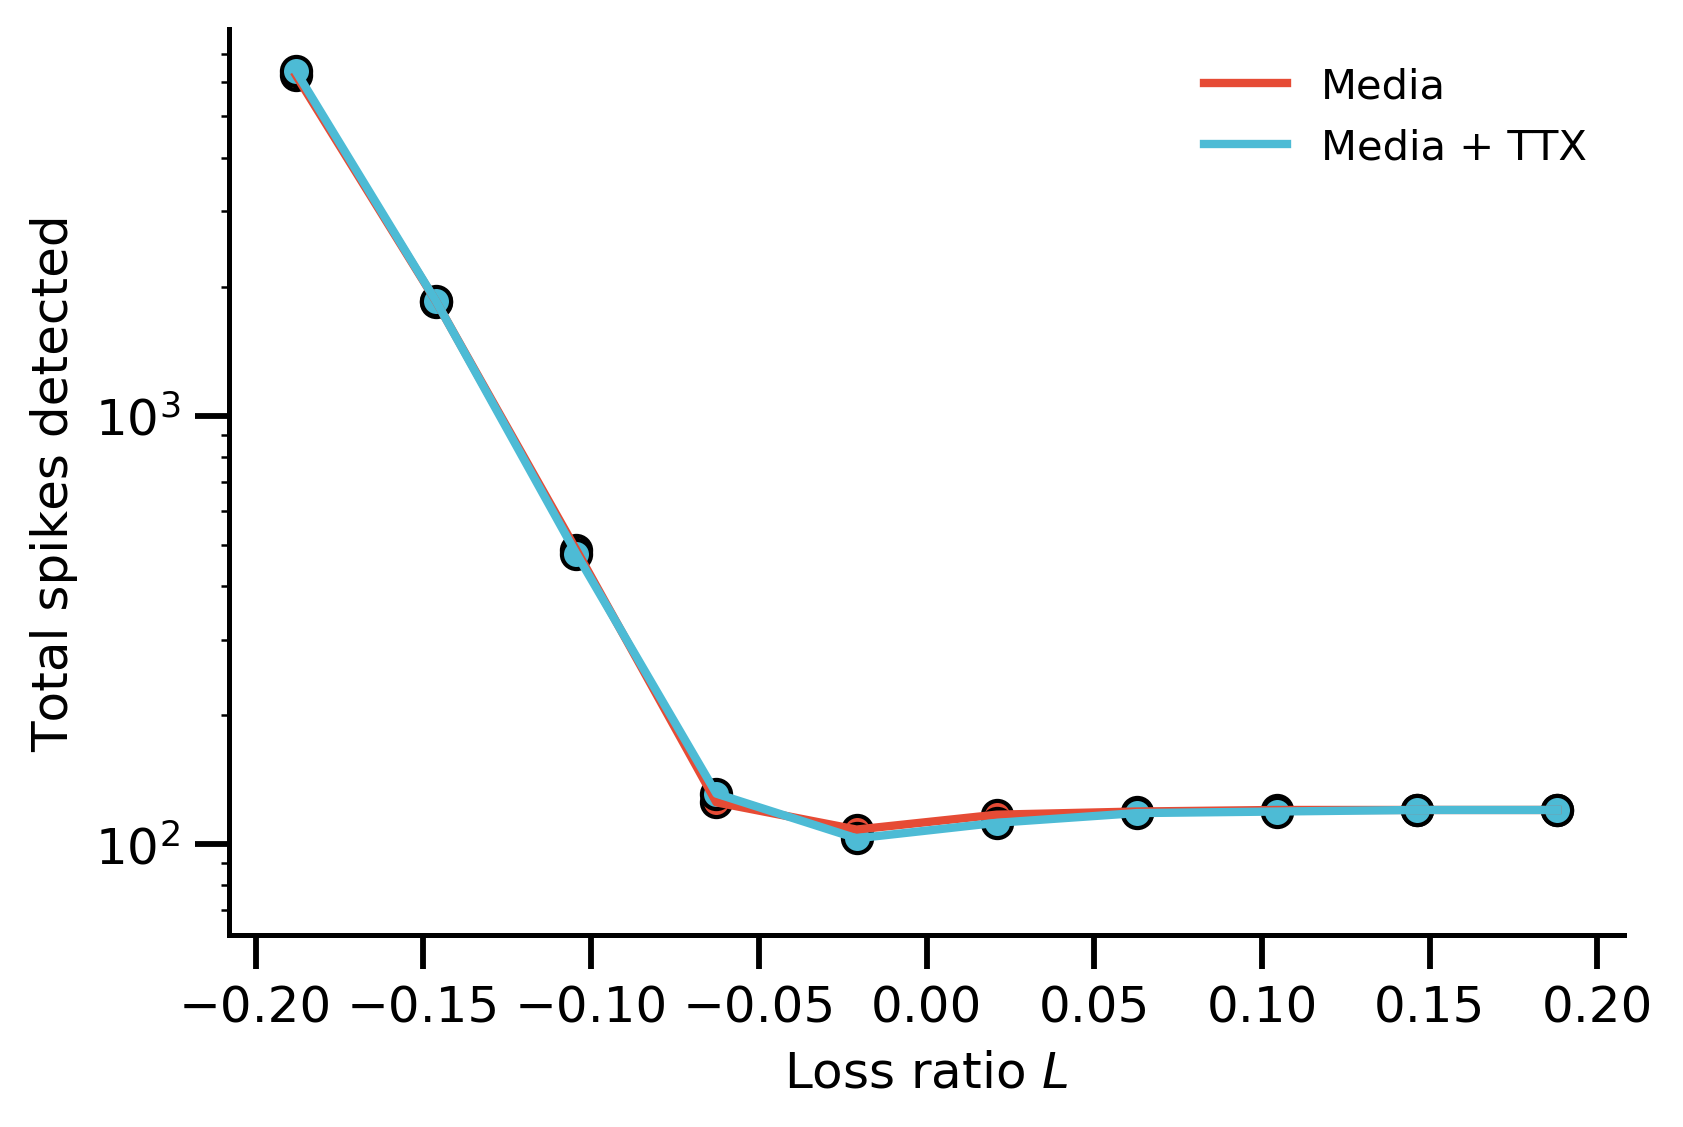

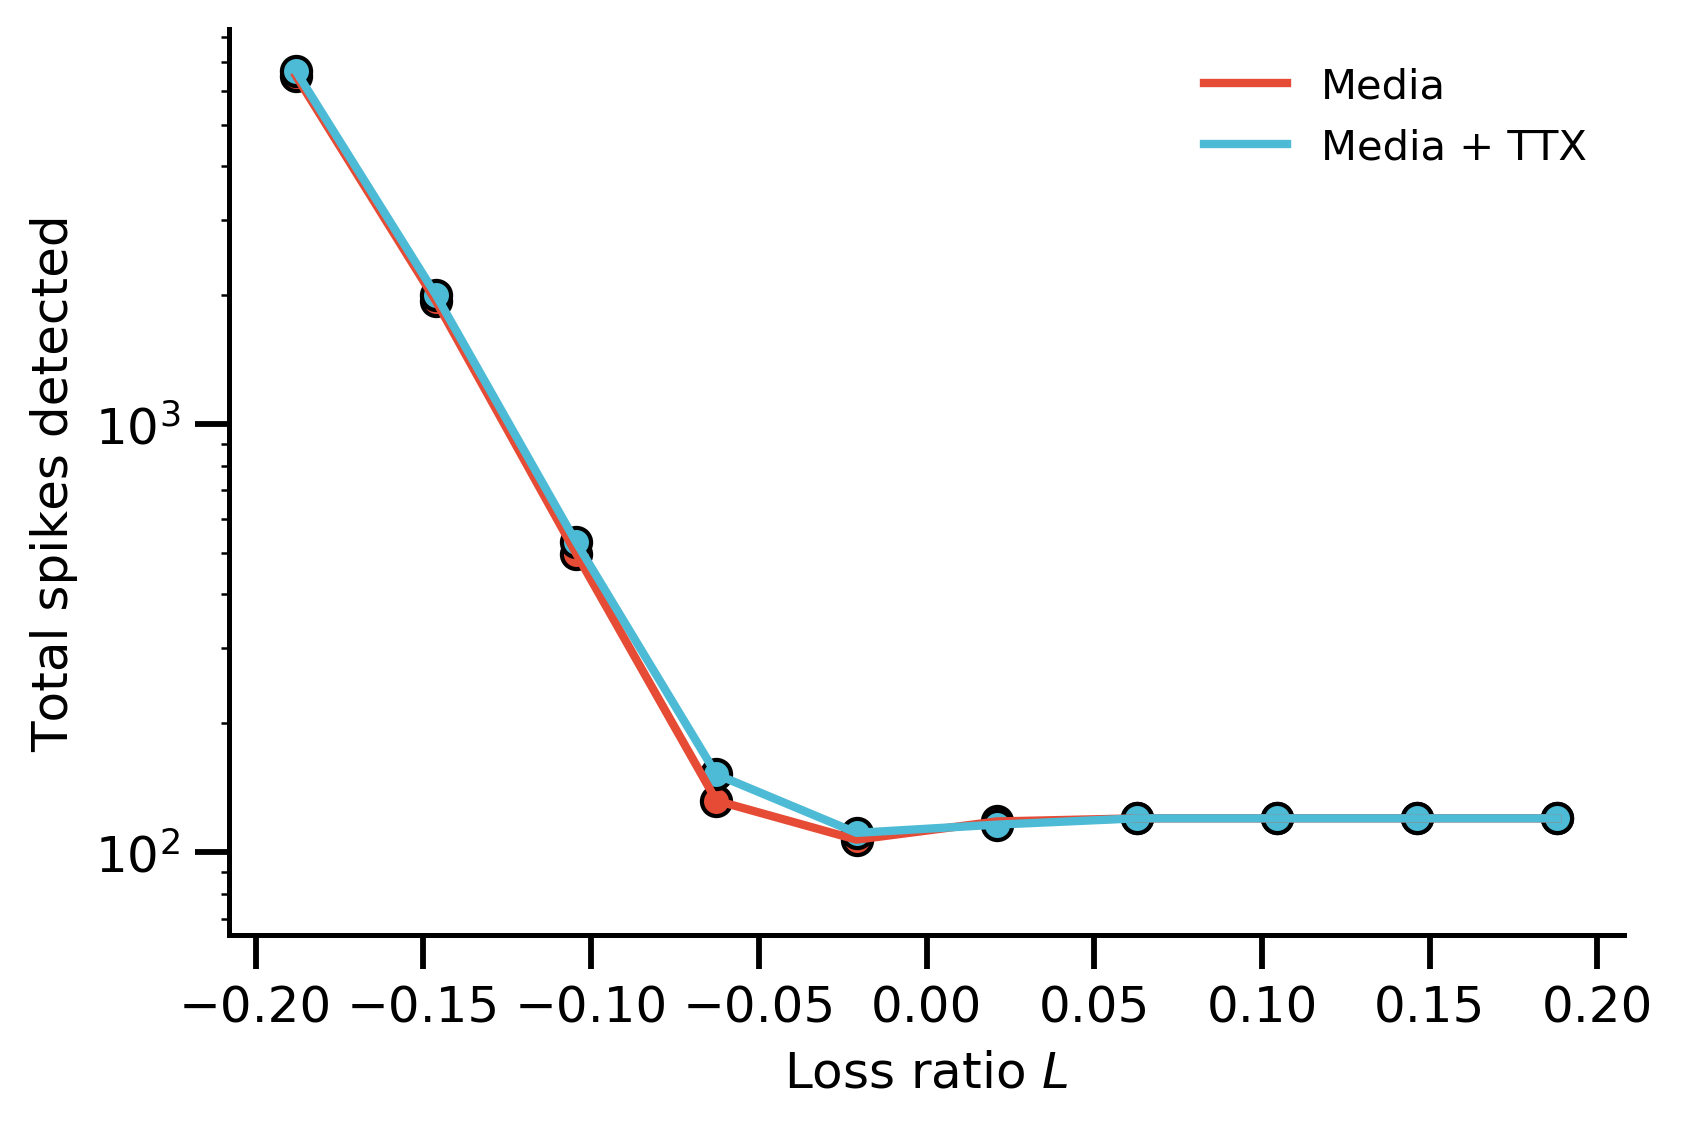

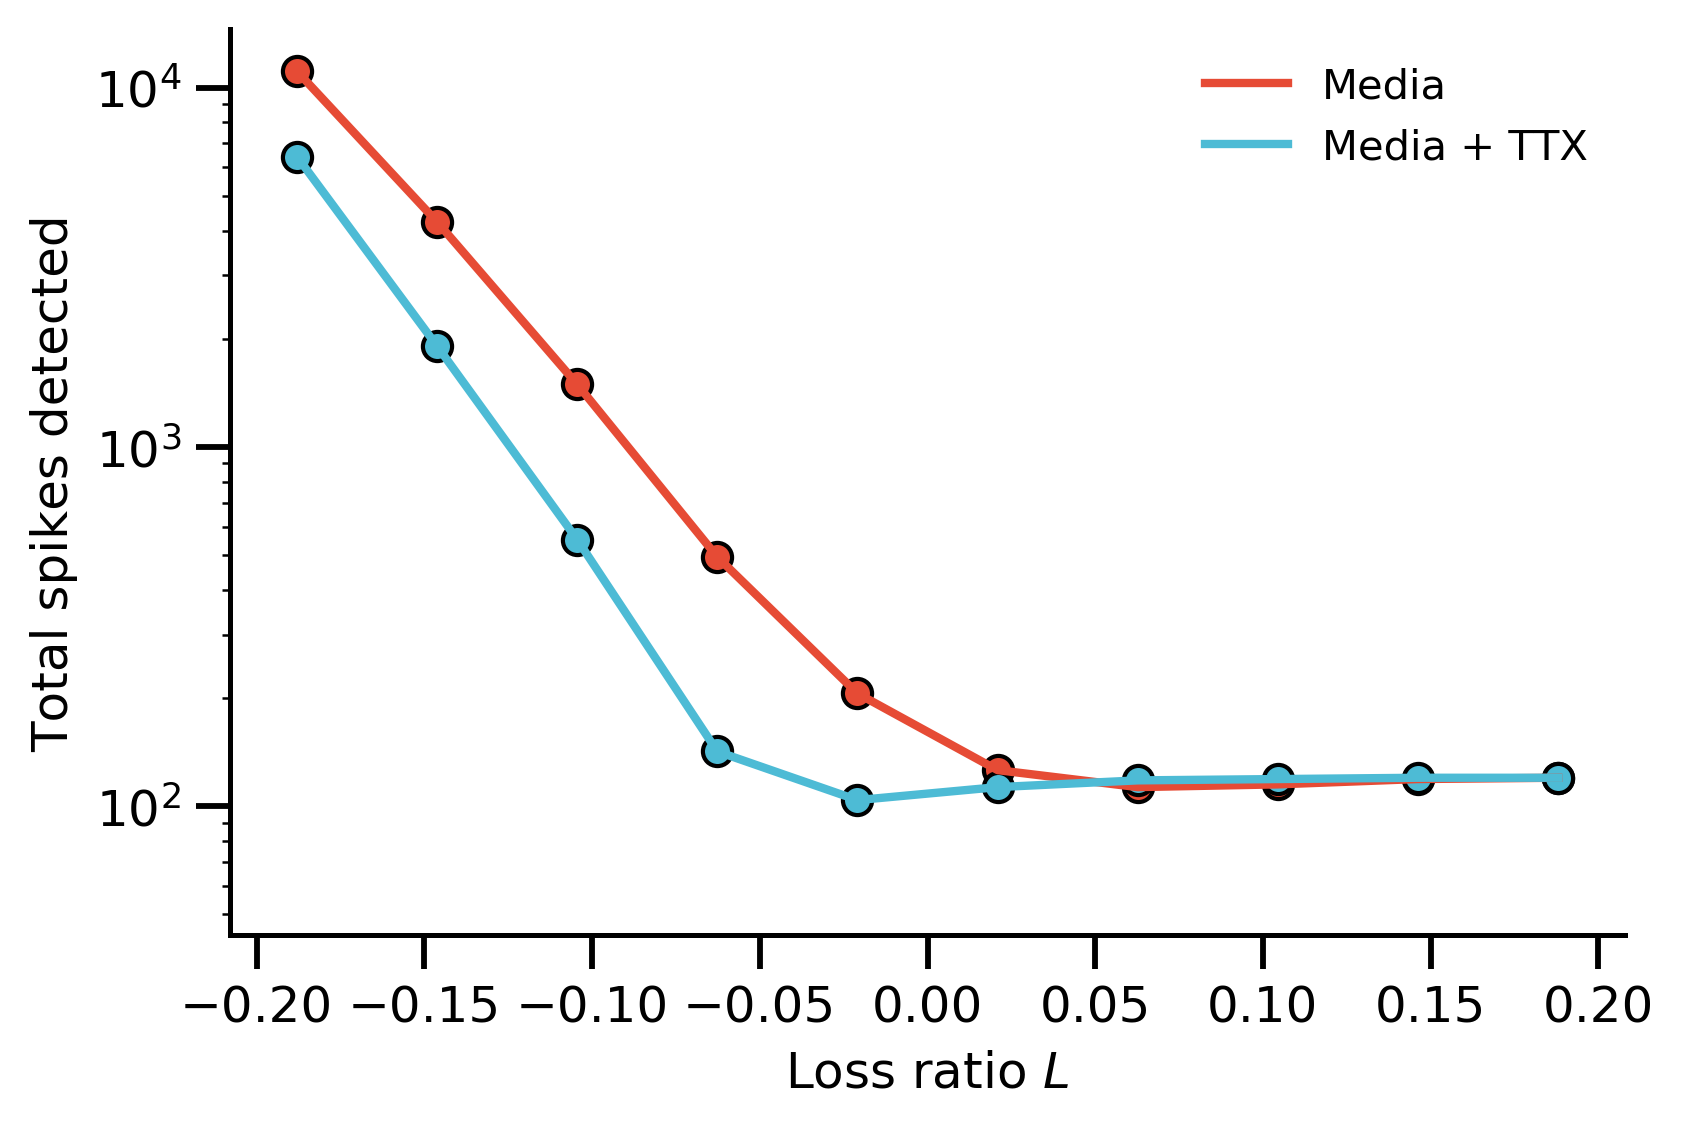

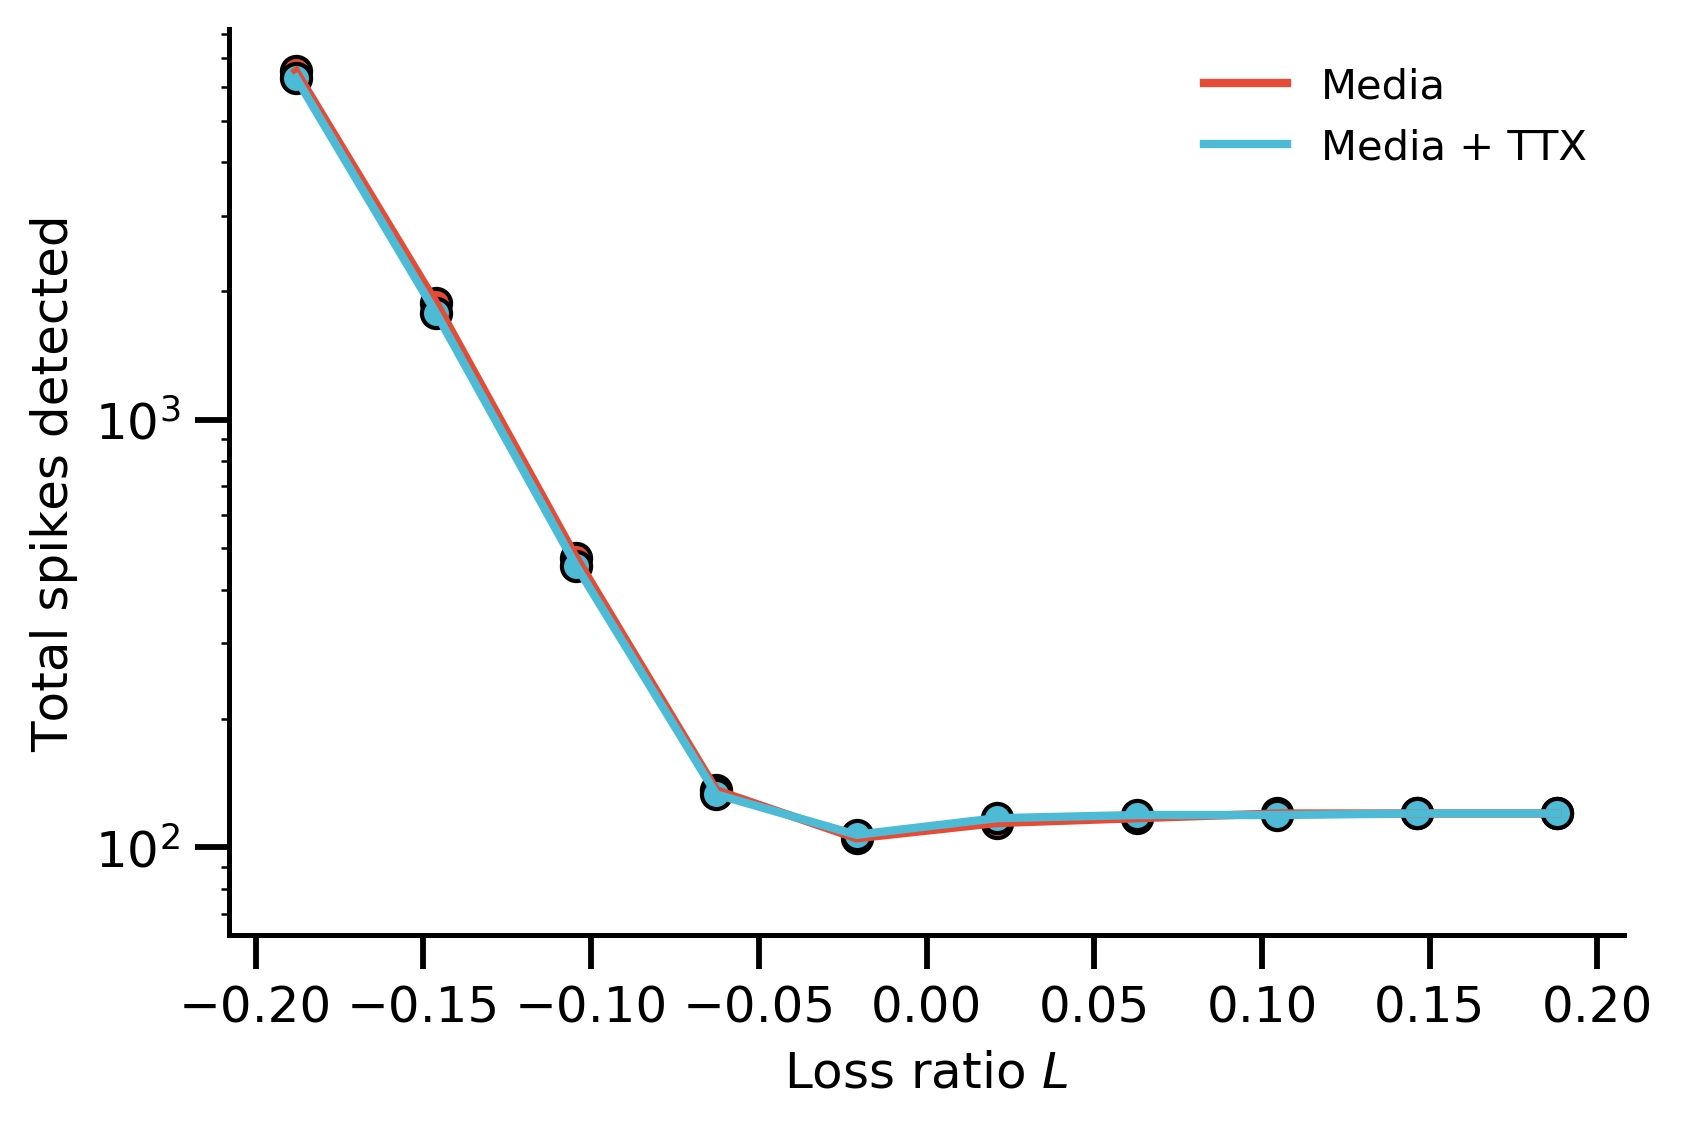

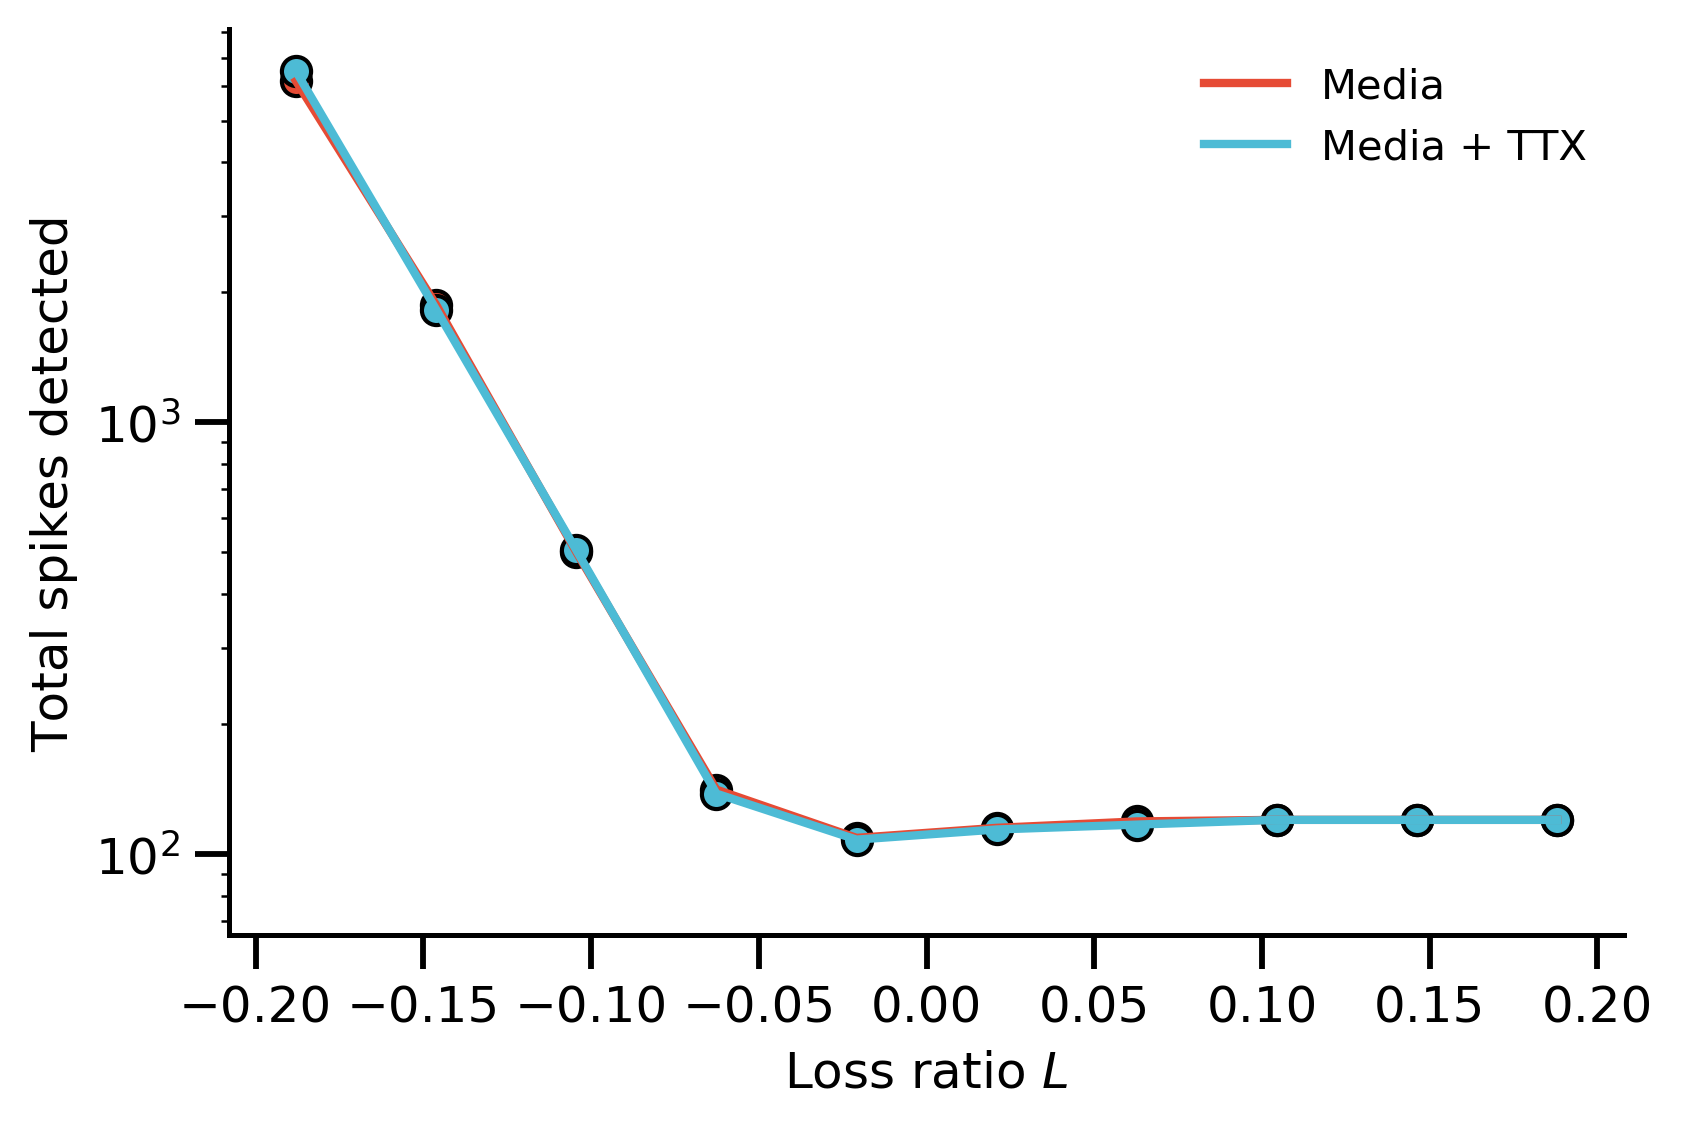

In [69]:
log_scale = True

for recording_date in np.unique(all_file_spike_df['recording_date']):
    recording_date_df = all_file_spike_df.loc[
        all_file_spike_df['recording_date'] == recording_date
    ]
    for slice_id in np.unique(recording_date_df['slice_number']):
        slice_data_df = recording_date_df.loc[
            recording_date_df['slice_number'] == slice_id 
        ]
        
        spike_counts_per_L = slice_data_df.groupby(['TTX', 'L']).agg('count')['spikeTime'].reset_index()
        
        
        with plt.style.context(splstyle.get_style('nature-reviews')):
            fig, ax = plt.subplots()


            ax.plot(spike_counts_per_L.loc[spike_counts_per_L['TTX'] == False]['L'], 
                    spike_counts_per_L.loc[spike_counts_per_L['TTX'] == False]['spikeTime'],
                    label='Media')

            ax.scatter(spike_counts_per_L.loc[spike_counts_per_L['TTX'] == False]['L'], 
                    spike_counts_per_L.loc[spike_counts_per_L['TTX'] == False]['spikeTime'])

            ax.plot(spike_counts_per_L.loc[spike_counts_per_L['TTX'] == True]['L'], 
                    spike_counts_per_L.loc[spike_counts_per_L['TTX'] == True]['spikeTime'],
                    label='Media + TTX')

            ax.scatter(spike_counts_per_L.loc[spike_counts_per_L['TTX'] == True]['L'], 
                    spike_counts_per_L.loc[spike_counts_per_L['TTX'] == True]['spikeTime'])


            ax.set_xlabel('Loss ratio $L$', size=12)
            ax.set_ylabel('Total spikes detected', size=12)

            ax.legend()
            
            ax.set_yscale('log')
        
            fig_folder = '/media/timsit/phts2/tempData/spikes/CWT_param_search/figures/'
            fig_name = 'recording_%s_slice_%s_pre_post_TTX_spikes_log_scale' % (recording_date, slice_id)
            fig.savefig(os.path.join(fig_folder, fig_name), dpi=300, bbox_inches='tight')
        
        